# Models

### The Dataset

As a refresher:
* Data from https://data.cityofnewyork.us/browse?q=poverty
* CSV file with ~80 columns and ~60,000 rows 
* Data types included:
    * Classification types encoded as integers (e.g. 1 if in poverty, 2 if not in poverty)
    * Floats for financial data (e.g. wages for the calendar year)

### Modeling approach

The poverty rate overall in New York City is roughly 20%. I'll use stratified test-train splits to improve my model.

Overview of modeling approach:
1. Compare a variety of models to see which may be best to focus on. (Random Forest and Balanced Random Forest had the 
best basic performance, so we'll focus on those.)
2. Create a regression model and examine the feature importance to get a better handle on the drivers of poverty.
3. Use LIME to understand model choices and develop trust in the models.

### Housekeeping part 1: imports and file prep

After importing we'll make some quick modifications to the data.

In [1]:
# Basic imports and setup
# See below for model-specific imports
from __future__ import print_function
from joblib import dump, load
import matplotlib.pyplot as plt
from multiprocessing import Pool
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import tempfile
import time

# Model-specific imports
from dask_ml.preprocessing import Categorizer, DummyEncoder

from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, RUSBoostClassifier
from imblearn.metrics import classification_report_imbalanced, geometric_mean_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.under_sampling import TomekLinks

import lime
import lime.lime_tabular

from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier, \
    RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PowerTransformer, QuantileTransformer, Normalizer
from sklearn.svm import SVC

from statsmodels.discrete.discrete_model import Logit, LogitResults

%matplotlib inline

# Temporarily turn off warnings if they get to be too much
#import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('data/all_years.csv', index_col=0)

# Group the columns into 1) raw input variables, 2) id variables of various things, 3) American Community Survey (census)
# variables, 4) NYC government-calculated variables, and 5) output variables.
#
# The ACS and NYC variables are generally calculated from the raw input variables - my initial expectation is that
# the raw input variables can be thought of as independent variables, and that the ACS and NYC variables are not
# independent even though they are not output variables.

raw_inp_vars = ['AGEP', 'Boro', 'CIT', 'DIS', 'ENG', 'ESR', 'Ethnicity', 'HHT', 'HIUnit_Head', 'HousingStatus', 'JWTR', 'LANX', 'MAR', 'MSP','NP', 'Off_Threshold', 'PreTaxIncome_PU', 'REL', 'SCH', 'SCHG', 'SCHL', 'SEX', 'TEN', 'WKHP', 'WKW', 'Year']
id_vars = ['HIUnit_ID', 'Povunit_ID', 'PWGTP', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'WGTP']
acs_vars = ['AgeCateg', 'INTP_adj', 'OI_adj', 'MRGP_adj', 'PA_adj', 'RETP_adj', 'RNTP_adj', 'SEMP_adj', 'SSIP_adj', 'SSP_adj',  'WAGP_adj']
nyc_vars = ['CitizenStatus',  'EducAttain', 'FTPTWork', 'FamType_PU', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_EITC', 'NYCgov_FICAtax', 'NYCgov_HEAP', 'NYCgov_Housing', 'NYCgov_Income', 'NYCgov_IncomeTax', 'NYCgov_MOOP', 'NYCgov_MedPremiums', 'NYCgov_MedSpending', 'NYCgov_Nutrition', 'NYCgov_REL', 'NYCgov_SFN', 'NYCgov_SFR', 'NYCgov_SNAP', 'NYCgov_SchoolBreakfast', 'NYCgov_SchoolLunch', 'NYCgov_Threshold', 'NYCgov_WIC', 'Povunit_Rel', 'SNAPUnit_Rel',  'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'TaxUnit_Rel', 'TotalWorkHrs_PU']
output_vars = ['NYCgov_PovGap', 'NYCgov_Pov_Stat', 'NYCgov_PovGapIndex', 'Off_Pov_Stat']
all_columns = raw_inp_vars + id_vars + acs_vars + nyc_vars + output_vars

In [3]:
# Create codes for the raw input variables that are number-coded, so we can create charts that make sense
raw_codes = {'Boro': {1: 'Bronx', 2: 'Brooklyn', 3: 'Manhattan', 4: 'Queens', 5: 'Staten Island'},
         'CIT': {1: 'Birth', 2: 'Territories', 3: 'US Parents', 4: 'Naturalized', 5: 'No'},
         'DIS': {0: 'NA', 1: 'Yes', 2: 'No'},
         'ENG': {0: '<5', 1: 'Very Well', 2: 'Well', 3: 'Not well', 4: 'Not at all', 5: 'Only Eng'},
         'ESR': {0: '<16', 1: 'EMP', 2:'EMP/NAW', 3: 'UNEMP', 4: 'AF', 5: 'AF/NAW', 6:'NILF'},
         'Ethnicity': {1: 'White', 2: 'Black', 3: 'Asian', 4: 'Hispanic', 5: 'Other'},
         'HHT': {0: 'NA', 1: 'MAR', 2: 'MNW', 3: 'WNM', 4: 'Malone', 5: 'MNAlone', 6: 'Walone', 7: 'WNalone'},
         'HIUnit_Head': {0: 'Not Head', 1: 'Head', 2: 'Not Head'},
         'HousingStatus': {0: 'NA', 1: 'Public', 2: 'Mitchell', 3: 'Subsidy', 4: 'Regulated', 5: 'OtherReg', 6: 'MarketRate', 7: 'NoCash', 8: 'OwnF&C', 9: 'Own-Mortgage'},
         'JWTR': {0: 'NA', 1: 'Car', 2: 'Bus', 3:'Streetcar', 4:'Subway', 5:'RR', 6:'Ferry', 7:'Taxi', 8:'Motorcycle', 9:'Bike', 10:'Walk', 11:'Home', 12: 'Other'},
         'LANX': {0: 'NA', 1: 'Yes', 2: 'Only Eng'},
         'MAR': {1: 'Married', 2:'Widowed', 3:'Divorced', 4:'Separated', 5:'Never Married'},
         'MSP': {0: 'NA', 1: 'Yes', 2:'Spouse absent', 3:'Widowed', 4:'Divorced', 5:'Separated', 6:'Never Married'},
         'REL': {0: 'Self', 1:'Spouse', 2:'Child', 3:'Adopted', 4:'Stepchild', 5:'Sibling', 6:'Parent', 7:'Grandchild', 8:'Parent-in-law', 9:'Child-in-law', 10:'Other', 11:'Boarder', 12:'Roommate', 13:'Partner', 14:'Foster', 15:'OtherNR', 16:'Inst', 17:'NonInst'},
         'SCH': {0: 'NA', 1: 'NoPast3Mos', 2:'Public', 3:'Private/Home'},
         'SCHG': {0: 'NA', 1:'Preschool', 2:'Kindergarten', 3:'1', 4:'2', 5:'3', 6:'4', 7:'5', 8:'6', 9:'7', 10:'8', 11:'9', 12:'10', 13:'11', 14:'12', 15:'College', 16:'Grad school'},
         'SCHL': {0: 'NA', 1:'None', 2:'Preschool', 3:'Kindergarten', 4:'1', 5:'2', 6:'3', 7:'4', 8:'5', 9:'6', 10:'7', 11:'8', 12:'9', 13:'10', 14:'11', 15:'12-NoDip', 16:'Diploma', 17:'GED', 18:'<1yrCollege', 19:'CollNoDegree', 20:'Associates', 21:'Bachelors', 22:'Masters', 23:'Professional', 24:'Doctorate'},
         'SEX': {1:'Male', 2:'Female'},
         'TEN': {0: 'NA', 1:'Mortage', 2:'Free&Clear', 3:'Rent', 4:'OccButNoRent'},
         'WKW': {0:'NA', 1:'50-52', 2:'48-49', 3:'40-47', 4:'27-39', 5:'14-26', 6:'<13'},
        }

# Create codes for the nyc variables that are number-coded, so we can create charts that make sense
nyc_codes = {
    'CitizenStatus': {1: 'Birth', 2: 'Naturalized', 3: 'No'},
    'EducAttain': {0: 'NA', 1:'<HS', 2:'HS', 3:'SomeCollege', 4:'Bachelors+'},
    'FTPTWork': {1:'FTYR', 2:'<FTYR', 3:'None'},
    'FamType_PU': {1:'Family', 2:'Couple', 3:'M+kid', 4:'W+kid', 5:'Mnokid', 6:'Wnokid', 7:'Unrelated', 8:'UnrelAlone'},
    'NYCgov_REL': {0:'Self', 1:'Spouse', 2:'Child', 3:'Sibling', 4:'Parent', 5:'Grandkid', 6:'Inlaw', 7:'OtherRel', 8:'Boarder', 9:'Roommate', 10:'Partner', 11:'FosterKid', 12:'OtherNonRel'},
    'NYCgov_SFR': {0: 'NA', 1:'NoKids', 2:'Kids', 3:'OneParent', 4:'Kid', 5:'Kid-Monly', 6:'Kid-Wonly'},
    'Povunit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'SNAPUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other'},
    'TaxUnit_FILER': {1:'Filer', 0:'Non-Filer'},
    'TaxUnit_FILESTAT': {0: 'NA', 1:'Joint', 2:'HH', 3:'MFS', 4:'Single'},
    'TaxUnit_FILETYPE': {0: 'NA', 1: 'Normal', 2:'Dependent', 3:'BelowThresh'},
    'TaxUnit_Rel': {1:'Head', 2:'Spouse/Ptnr', 3:'Child', 4:'Other', 5:'EIC', 6:'Relative'},
    'TotalWorkHrs_PU': {1:'3500+', 2:'2340-3500', 3:'1750-2340', 4:'<1750', 5:'None'}
    }

In [4]:
# Key dataframes of interest
# All 2016 data
all_2016 = df[df.Year == 2016]

# Our data set contains two sets of weights: household weights and person weights.  
# We need to separate out each column by whether it should be weighted as a household variable or a person variable.
# Lists to create weighted columns, separated based on whether they are personal or household statistics.
personal_vars = ['AGEP', 'Boro', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'ENG', 'LANX', 'MSP', 'MAR', 'NYCgov_EITC', 'WKW', 'WKHP', 'DIS', 'JWTR', 'WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 'OI_adj', 'TaxUnit_Rel', 'NYCgov_REL', 'NYCgov_SFR', 'SNAPUnit_Rel', 'TaxUnit_FILER', 'TaxUnit_FILESTAT', 'TaxUnit_FILETYPE', 'Ethnicity', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork', 'PWGTP'] 
pu_vars = ['MRGP_adj', 'RNTP_adj', 'NP', 'TEN', 'HHT', 'FamType_PU', 'HousingStatus', 'TotalWorkHrs_PU', 'PreTaxIncome_PU', 'NYCgov_Income', 'NYCgov_Threshold', 'NYCgov_Pov_Stat',  'NYCgov_Housing', 'NYCgov_Childcare', 'NYCgov_Commuting', 'NYCgov_MOOP', 'NYCgov_MedSpending', 'NYCgov_MedPremiums', 'NYCgov_HEAP', 'NYCgov_WIC', 'NYCgov_SNAP', 'NYCgov_SchoolLunch', 'NYCgov_SchoolBreakfast', 'NYCgov_Nutrition', 'NYCgov_FICAtax', 'NYCgov_IncomeTax', 'Off_Threshold', 'Off_Pov_Stat', 'NYCgov_PovGap', 'NYCgov_PovGapIndex', 'WGTP']
other_vars = ['HIUnit_Head', 'HIUnit_ID', 'NYCgov_SFN', 'Povunit_ID', 'Povunit_Rel', 'REL', 'SERIALNO', 'SNAPUnit_ID', 'SPORDER', 'TaxUnit_ID', 'Year']

### Feature Engineering - Adding New Poverty-Unit Variables Based on Personal Variables
Here's where we're actually adding new variables based on old variables.

From the personal-level features, we'll create new household-level features (e.g. number of kids, mean salary among 
adults, count of people making more than $30k, count of adults working between 14-26 hours/week, minimum salary among
adults working more than 26 hours/week, etc.)

This is a wall of text, not much exciting narrative here.

(Note on programming style/choices: the first function 'add_pu_columns' below is a real function, although it has a
kludge in case one of the summary calculations fails. (That happens rarely, but it's still a code smell.)

The second function, however, is not really a 'real' function; it's heavily hand-coded and relies on custom choices of
various groupings.  It was put into a function solely to comply with the DRY principle - in particular, this function
will typically be run twice (once for the whole grouping, and possibly once for a model run without the 'financial' 
features).  By putting it into a function for DRY purposes, we at least avoid accidentally running different code when we 
mean to run the same code).

In [5]:
def add_pu_columns(df, groups, group_names, categories, category_names, column):
    """
    Adds columns to dataframe 'df' containing calculations by poverty-unit, restricted by categories, considering groups.
    Calculations include any(), all(), min(), max(), count(), sum(), mean(), and % in given category.
    Input: a dataframe with multi-index consisting of 'SERIALNO', 'Povunit_ID', and 'SPORDER'; a set of masks and list of
    names for the groups; a set of masks and a list of names for the categories; and the column of interest.
    Output: no return value.  Inserts a series of columns into the dataframe including min, max, count, sum, any, all,
    % of total, and mean - within households, focusing on the groups and categories of interest. 
    """
    
    for group, group_name in zip(groups, group_names):
        for category, category_name in zip(categories, category_names):
            stacked = df[column][group & category].stack().groupby(['SERIALNO', 'Povunit_ID'])
            anys = stacked.any()
            # would love to use .all() here, but it would always be True because we filtered out everyone else
            mins = stacked.min()
            maxes = stacked.max()
            counts = stacked.count()
            sums = stacked.sum()
            means = sums/counts
            # The divisor below only restricts by 'groups' - so the final calculation is within a household, within
            # the group of interest (e.g. adults), what % is in the category of interest (e.g. works 40 hrs/week)
            divisor_for_percents = df[column][group].stack().groupby(['SERIALNO', 'Povunit_ID']).count()
            try:
                percents = counts.div(divisor_for_percents, axis=0)
                alls = percents == 1
            except: # if the calculation failed, leave percents and alls as a column of zeros
                df_len = len(df.groupby(['SERIALNO', 'Povunit_ID']).sum())
                percents = np.zeros(df_len)
                alls = np.zeros(df_len)
            
            # loop through, put in the dataframe, and fill in NAs of appropriate type
            series_and_names = zip([anys, alls, mins, maxes, counts, sums, means, percents], 
                                  ['any', 'all', 'min', 'max', 'count', 'sum', 'mean', '%'])
            for series, series_name in series_and_names:
                column_title = series_name + '_' + group_name + '_' + category_name
                df[column_title] = series
                if series_name in ['any', 'all']:
                    df[column_title] = df[column_title].fillna(False)
                else:
                    df[column_title] = df[column_title].fillna(0)
                    
def engineer_features(df, include_financials=True):
    """Create features for the dataframe. This function is heavily custom and was solely created for DRY-ness.
    Input: a poverty dataframe and whether or not to include financial features.
    Output: returns a copy of the dataframe summarized by poverty-unit, with *only* the new features included. 
    Prints progess updates to the screen as it goes.
    """

    time_0 = time.time()

    # Create dataframe to house new features 
    dfc = df.copy() # read as 'X new features'

    # Count the original # of features - later we'll just slice out the new features
    # Keep in mind that 'SERIALNO' and 'Povunit_ID' will go into the index, so we need to subtract 2 columns
    features_to_mask = len(dfc.columns) - 2
    
    # This is the largest # of people in a household; when we group the columns below, for each existing feature we'll
    # create one column for each person in a household - so we'll need to know this number at the end when we want to 
    # mask our existing features
    max_ppl = dfc.SPORDER.max()

    # First, some categoricals have odd ordering; remap them
    fix_orders = {'ENG': {0:0, 4:1, 3:2, 2:3, 1:4, 5:5}, 'WKW': {0:0, 6:1, 5:2, 4:3, 3:4, 2:5, 1:6}, 
                  'TotalWorkHrs_PU': {5:0, 4:1, 3:2, 2:3, 1:4}}
    dfc['ENG'] = dfc['ENG'].map(fix_orders['ENG'])
    dfc['WKW'] = dfc['WKW'].map(fix_orders['WKW'])
    dfc['TotalWorkHrs_PU'] = dfc['TotalWorkHrs_PU'].map(fix_orders['TotalWorkHrs_PU'])

    # Add column for total personal income
    if include_financials:
        dfc['TINP'] = dfc.WAGP_adj + dfc.INTP_adj + dfc.SEMP_adj + dfc.SSP_adj + dfc.SSIP_adj + \
                        dfc.PA_adj + dfc.RETP_adj + dfc.OI_adj

    # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
    dfc = dfc.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

    # Create masks for age groups to use in creating new features
    mask_adult = (dfc.AgeCateg == 2) | (dfc.AgeCateg == 3)
    mask_65_plus = dfc.AgeCateg == 3
    mask_18_64 = dfc.AgeCateg == 2
    mask_kid = dfc.AgeCateg == 1
    mask_any_age = dfc.AgeCateg != 0
    mask_any = mask_any_age

    # add columns with age only, no categories
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']
    add_pu_columns(dfc, groups, group_names, [mask_any_age], ['age'], 'AGEP')

    # add columns for CIT
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_non_cit = dfc.CIT == 5
    mask_cit = (dfc.CIT != 5) & (dfc.CIT != 0)
    mask_naturalized = dfc.CIT == 4

    categories = [mask_non_cit, mask_cit, mask_naturalized, mask_any]
    category_names = ['non-cit', 'citizen', 'naturalized_cit', 'any_CIT']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'CIT')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with CIT')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for SCHL
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_college_degree = (dfc.SCHL >= 21)
    mask_HS_diploma = (dfc.SCHL >= 17)
    mask_no_diploma = (dfc.SCHL <= 16)

    categories = [mask_college_degree, mask_HS_diploma, mask_no_diploma, mask_HS_diploma & ~mask_college_degree, mask_any]
    category_names = ['college', 'HS', 'no_diploma', 'diploma_no_bachelors', 'any_SCHL']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'SCHL')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SCHL')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for SEX
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_male = dfc.SEX == 1
    mask_female = dfc.SEX == 2

    categories = [mask_male, mask_female, mask_any]
    category_names = ['male', 'female', 'any_SEX']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'SEX')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SEX')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for English ability (ENG)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # Keep in mind we switched ENG above so that 0 is NA, 1 is not at all, 2 is not very well, ..., 5 is only English
    mask_no_english = dfc.ENG == 1
    mask_eng_nvw = dfc.ENG == 2
    mask_sep_well = dfc.ENG == 3
    mask_eng_vw = dfc.ENG == 4
    mask_only_eng = dfc.ENG == 5

    categories = [mask_no_english, mask_eng_nvw, mask_sep_well, mask_eng_vw, mask_only_eng, mask_any]
    category_names = ['ENG_no', 'ENG_nvw', 'ENG_well', 'ENG_vw', 'ENG_only', 'ENG_any']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'ENG')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with ENG')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for marital status (MSP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_married = (dfc.MSP == 1) | (dfc.MSP == 2)
    mask_widowed = dfc.MSP == 3
    mask_sep_div = (dfc.MSP == 4) | (dfc.MSP == 5)
    mask_not_married = dfc.MSP == 6

    categories = [mask_married, mask_widowed, mask_sep_div, mask_not_married, mask_any]
    category_names = ['married', 'widowed', 'sep/divorced', 'not_married', 'any_MSP']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'MSP')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with MSP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for weeks worked (WKW) -- this is *weeks* worked last year, not *hours per week* (that's WKHP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # Keep in mind we switched WKW above so that 0 is none, 1 is <14 weeks, 2 is 14-26 weeks, etc.
    mask_0_WKW = dfc.WKW == 0
    mask_u14_WKW = dfc.WKW == 1
    mask_14_26_WKW = dfc.WKW == 2
    mask_27_39_WKW = dfc.WKW == 3
    mask_40_47_WKW = dfc.WKW == 4
    mask_48_49_WKW = dfc.WKW == 5
    mask_50_52_WKW = dfc.WKW == 6

    categories = [mask_0_WKW, mask_u14_WKW, mask_14_26_WKW, mask_27_39_WKW, mask_40_47_WKW, mask_48_49_WKW, mask_50_52_WKW, 
                 (mask_40_47_WKW | mask_48_49_WKW | mask_50_52_WKW), ~mask_0_WKW, mask_any]
    category_names = ['no_work', '<14WKW', '14-26WKW', '27-39WKW', '40-47WKW', '48-49WKW', '50-52WKW', '>40WKW', 'nonzero_WKW',
                     'any_WKW']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'WKW')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with WKW')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for usual hours worked per week last 12 months (WKHP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_0_WKHP = dfc.WKHP == 0
    mask_u10_WKHP = dfc.WKHP < 10
    mask_u15_WKHP = dfc.WKHP < 15
    mask_u20_WKHP = dfc.WKHP < 20
    mask_u30_WKHP = dfc.WKHP < 30
    mask_u40_WKHP = dfc.WKHP < 40
    mask_u50_WKHP = dfc.WKHP < 50
    mask_50_plus_WKHP = dfc.WKHP >= 50
    mask_40_plus_WKHP = dfc.WKHP >= 40

    categories = [mask_0_WKHP, mask_u10_WKHP, mask_u15_WKHP, mask_u20_WKHP, mask_u30_WKHP, mask_u40_WKHP, 
                  mask_u50_WKHP, mask_50_plus_WKHP, mask_40_plus_WKHP, mask_any]
    category_names = ['no_work_hrs', '<10_work_hrs', '<15_work_hrs', '<20_work_hrs', '<30_work_hrs', '<40_work_hrs', 
                      '<50_work_hrs', '50_plus_work_hrs', '40_plus_work_hrs', 'any_WKHP']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'WKHP')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with WKHP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for disability status (DIS)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_DIS = dfc.DIS == 1
    mask_not_DIS = dfc.DIS == 2

    categories = [mask_DIS, mask_not_DIS, mask_any]
    category_names = ['DIS', 'not_DIS', 'any_DIS']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'DIS')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with DIS')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for number of people (NP)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_1_NP = dfc.NP == 1
    mask_2_NP = dfc.NP == 2
    mask_3_NP = dfc.NP == 3
    mask_4_NP = dfc.NP == 4
    mask_5_NP = dfc.NP == 5
    mask_p5_NP = dfc.NP > 5
    mask_p6_NP = dfc.NP > 6
    mask_p8_NP = dfc.NP > 8
    mask_p10_NP = dfc.NP > 10
    mask_p12_NP = dfc.NP > 12

    categories = [mask_1_NP, mask_2_NP, mask_3_NP, mask_4_NP, mask_5_NP, mask_p5_NP, mask_p6_NP, mask_p8_NP, mask_p10_NP, 
                  mask_p12_NP, mask_any]
    category_names = ['NP1', 'NP2', 'NP3', 'NP4', 'NP5', 'NP>5', 'NP>6', 'NP>8', 'NP>10', 'NP>12', 'anyNP']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'NP')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with NP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for means of transportation to work (JWTR)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    categories = [mask_any]
    category_names = ['work_trans']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'JWTR')
    # Since only doing this to get means/avgs on JWTR, no need to add the 'AGEP' version here
    #add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with JWTR')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for wages (WAGP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_0_WAG = dfc.WAGP_adj == 0
    mask_u10_WAG = dfc.WAGP_adj < 10000
    mask_u15_WAG = dfc.WAGP_adj < 15000
    mask_u20_WAG = dfc.WAGP_adj < 20000
    mask_u25_WAG = dfc.WAGP_adj < 25000
    mask_u30_WAG = dfc.WAGP_adj < 30000
    mask_u35_WAG = dfc.WAGP_adj < 35000
    mask_u40_WAG = dfc.WAGP_adj < 40000
    mask_u45_WAG = dfc.WAGP_adj < 45000
    mask_u50_WAG = dfc.WAGP_adj < 50000
    mask_u60_WAG = dfc.WAGP_adj < 60000
    mask_u70_WAG = dfc.WAGP_adj < 70000
    mask_u80_WAG = dfc.WAGP_adj < 80000

    categories = [mask_0_WAG, mask_u10_WAG, mask_u15_WAG, mask_u20_WAG, mask_u25_WAG, mask_u30_WAG,  mask_u35_WAG, 
                  mask_u40_WAG, mask_u45_WAG, mask_u50_WAG, mask_u60_WAG, mask_u70_WAG, mask_u80_WAG, mask_any]
    category_names = ['WAG0', 'WAG<10', 'WAG<15', 'WAG<20', 'WAG<25', 'WAG<30', 'WAG<35', 
                      'WAG<40', 'WAG<45', 'WAG<50', 'WAG<60', 'WAG<70', 'WAG<80', 'WAG_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'WAGP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with WAGP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for interest income (INTP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_INT = dfc.INTP_adj <= 0
    mask_INT_1q = (dfc.INTP_adj > 0) & (dfc.INTP_adj <= 400)
    mask_INT_2q = (dfc.INTP_adj > 400) & (dfc.INTP_adj <= 4000)
    mask_INT_3q = (dfc.INTP_adj > 4000) & (dfc.INTP_adj <= 15000)
    mask_INT_4q = dfc.INTP_adj > 15000

    categories = [mask_0_INT, mask_INT_1q, mask_INT_2q, mask_INT_3q, mask_INT_4q, mask_any]
    category_names = ['INT0', 'INT1q', 'INT2q', 'INT3q', 'INT4q', 'INT_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'INTP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with INTP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for self-employment income (SEMP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_SEMP = dfc.SEMP_adj <= 0
    mask_SEMP_1q = (dfc.SEMP_adj > 0) & (dfc.SEMP_adj <= 5000)
    mask_SEMP_2q = (dfc.SEMP_adj > 5000) & (dfc.SEMP_adj <= 15000)
    mask_SEMP_3q = (dfc.SEMP_adj > 15000) & (dfc.SEMP_adj <= 35000)
    mask_SEMP_4q = dfc.SEMP_adj > 35000

    categories = [mask_0_SEMP, mask_SEMP_1q, mask_SEMP_2q, mask_SEMP_3q, mask_SEMP_4q, mask_any]
    category_names = ['SEMP0', 'SEMP1q', 'SEMP2q', 'SEMP3q', 'SEMP4q', 'SEMP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'SEMP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SEMP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for social security income (SSP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    # min 10, 25% 8000, 50% 12,000, 75% 18,000, max 50,000
    mask_0_SSP = dfc.SSP_adj <= 0
    mask_SSP_1q = (dfc.SSP_adj > 0) & (dfc.SSP_adj <= 8000)
    mask_SSP_2q = (dfc.SSP_adj > 8000) & (dfc.SSP_adj <= 12000)
    mask_SSP_3q = (dfc.SSP_adj > 12000) & (dfc.SSP_adj <= 18000)
    mask_SSP_4q = dfc.SSP_adj > 18000

    categories = [mask_0_SSP, mask_SSP_1q, mask_SSP_2q, mask_SSP_3q, mask_SSP_4q, mask_any]
    category_names = ['SSP0', 'SSP1q', 'SSP2q', 'SSP3q', 'SSP4q', 'SSP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'SSP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SSP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for supplemental security income (SSIP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_SSIP = dfc.SSIP_adj <= 0 
    mask_SSIP_1q = (dfc.SSIP_adj > 0) & (dfc.SSIP_adj <= 5500) 
    mask_SSIP_2q = (dfc.SSIP_adj > 5500) & (dfc.SSIP_adj <= 8000) 
    mask_SSIP_3q = (dfc.SSIP_adj > 8000)

    categories = [mask_0_SSIP, mask_SSIP_1q, mask_SSIP_2q, mask_SSIP_3q, mask_any]
    category_names = ['SSIP0', 'SSIP1q', 'SSIP2q', 'SSIP3q', 'SSIP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'SSIP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with SSIP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for public assistance income (PA_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_0_PA = dfc.PA_adj <= 0 
    mask_PA_1q = (dfc.PA_adj > 0) & (dfc.PA_adj <= 900) 
    mask_PA_2q = (dfc.PA_adj > 900)

    categories = [mask_0_PA, mask_PA_1q, mask_PA_2q, mask_any]
    category_names = ['PA0', 'PA1q', 'PA2q', 'PA_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'PA_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with PA')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for retirement income (RETP_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_RETP_1q = (dfc.RETP_adj > 0) & (dfc.RETP_adj <= 6000) 
    mask_RETP_2q = (dfc.RETP_adj > 6000) & (dfc.RETP_adj <= 13400) 
    mask_RETP_3q = (dfc.RETP_adj > 13400)

    categories = [mask_RETP_1q, mask_RETP_2q, mask_RETP_3q, mask_any]
    category_names = ['RETP1q', 'RETP2q', 'RETP3q', 'RETP_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'RETP_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with RETP')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for other income (OI_adj)
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    # cutoffs taken from quartiles of nonzero values
    mask_OI_1q = (dfc.OI_adj > 0) & (dfc.OI_adj <= 2000) 
    mask_OI_2q = (dfc.OI_adj > 2000) & (dfc.OI_adj <= 6000) 
    mask_OI_3q = (dfc.OI_adj > 6000)

    categories = [mask_OI_1q, mask_OI_2q, mask_OI_3q, mask_any]
    category_names = ['OI1q', 'OI2q', 'OI3q', 'OI_any']

    if include_financials:
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'OI_adj')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with OI')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    # add columns for ethnicity
    groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
    group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

    mask_white = dfc.Ethnicity == 1
    mask_black = dfc.Ethnicity == 2
    mask_asian = dfc.Ethnicity == 3
    mask_hisp = dfc.Ethnicity == 4
    mask_other = dfc.Ethnicity == 5

    categories = [mask_white, mask_black, mask_asian, mask_hisp, mask_other, mask_any]
    category_names = ['White', 'Black', 'Asian', 'Hisp', 'ETH_other', 'ETH_any']

    add_pu_columns(dfc, groups, group_names, categories, category_names, 'Ethnicity')
    add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')
    print('done with Ethnicity')
    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s so far')

    if include_financials:
        # add columns for total personal income that we added above ('TINP')
        groups = [mask_adult, mask_65_plus, mask_18_64, mask_kid, mask_any_age]
        group_names = ['adult', '65+', '18-64', 'kid', 'anyage']

        mask_0_TINP = dfc.TINP == 0
        mask_u10_TINP = dfc.TINP < 10000
        mask_u15_TINP = dfc.TINP < 15000
        mask_u20_TINP = dfc.TINP < 20000
        mask_u25_TINP = dfc.TINP < 25000
        mask_u30_TINP = dfc.TINP < 30000
        mask_u35_TINP = dfc.TINP < 35000
        mask_u40_TINP = dfc.TINP < 40000
        mask_u45_TINP = dfc.TINP < 45000
        mask_u50_TINP = dfc.TINP < 50000
        mask_u60_TINP = dfc.TINP < 60000
        mask_u70_TINP = dfc.TINP < 70000
        mask_u80_TINP = dfc.TINP < 80000

        categories = [mask_0_TINP, mask_u10_TINP, mask_u15_TINP, mask_u20_TINP, mask_u25_TINP, mask_u30_TINP,  mask_u35_TINP, 
                      mask_u40_TINP, mask_u45_TINP, mask_u50_TINP, mask_u60_TINP, mask_u70_TINP, mask_u80_TINP, mask_any]
        category_names = ['TINP0', 'TINP<10', 'TINP<15', 'TINP<20', 'TINP<25', 'TINP<30', 'TINP<35', 
                          'TINP<40', 'TINP<45', 'TINP<50', 'TINP<60', 'TINP<70', 'TINP<80', 'TINP_any']

        add_pu_columns(dfc, groups, group_names, categories, category_names, 'TINP')
        add_pu_columns(dfc, groups, group_names, categories, category_names, 'AGEP')

    time_took = time.time() - time_0
    print('took ' + str(time_took) + ' s')

    # Only return the new features that we engineered
    # The variables features_to_mask and max_ppl were created at the beginning of this function
    columns_to_mask = features_to_mask * max_ppl
    dfc = dfc.iloc[:, columns_to_mask:].copy()

    # We ended up with multi-level column headers - just keep the top level
    dfc.columns = dfc.columns.get_level_values(0)
    
    return(dfc)

#new_features = engineer_features(all_2016, include_financials=True)

#new_features.to_csv('data/EngineeredFeatures.csv')

### Feature Engineering - Putting Personal Features into Poverty Unit Rows
Our dataset contains people in poverty units (a household may contain one or more poverty units). The entire 
poverty unit either is or is not in poverty, but the data set as constructed has people in different rows (the data is
not tidy).

To tidy up, we'll move information on all the people in the poverty unit, into the row for that poverty unit.
Instead of having 3 people in a poverty unit represented by different rows, we'll put all three people in
the same row but different columns. The columns will be named 'AGEP_1', 'AGEP_2', 'AGEP_3', etc, with zero values in all
columns where person n does not exist.

There are three main columns of interest for this:
* SERIALNO is the serial number of each household.
* PovUnit_ID is the serial number of the poverty unit within the household (1-18). Each household can have more than one poverty unit (although the vast majority of households have only one poverty unit).
* SPORDER is the serial number of a person in the household (1-20). Note that the dataset only assigns serial numbers to
the people in the *household*, not the *poverty unit*.  This means that if for example a household has two poverty units,
the first with two people and the second with three people, the head of the second poverty unit will have SPORDER of 3,
not 1.  (One-based counting scheme) This is not a problem, but a particularity to be aware of when looking at dataset
rows for reference.

Also, there are some poverty-unit-level columns (e.g. 'TotalWorkHrs_PU', the number of work hours in the poverty unit)
that have the same value for each person in the poverty unit; we'll collect those separately.

So the strategy in the next section is to create dataframes X_pers and X_pu, containing respectively the personal and
poverty-unit features for each household.  We'll join those together, and then at the end add in all the new features we created in the last section.

In [6]:
def pers_and_pu_features(df, include_financials=True, target_column='NYCgov_Pov_Stat'):
    """Create personal and poverty-unit features for the dataframe. No new features are created, just 'tidy'-ing the data.
    Input: a poverty dataframe, whether or not to include financial features, and the target column.
    Output: returns a copy of the dataframe, tidy-ed up, with poverty units in rows and only features of interest in 
    columns. Prints progess updates to the screen as it goes.
    """

    dfc = df.copy()
    
    # First, some categoricals have odd ordering; remap them
    fix_orders = {'ENG': {0:0, 4:1, 3:2, 2:3, 1:4, 5:5}, 'WKW': {0:0, 6:1, 5:2, 4:3, 3:4, 2:5, 1:6}, 
                  'TotalWorkHrs_PU': {5:0, 4:1, 3:2, 2:3, 1:4}}
    dfc['ENG'] = dfc['ENG'].map(fix_orders['ENG'])
    dfc['WKW'] = dfc['WKW'].map(fix_orders['WKW'])
    dfc['TotalWorkHrs_PU'] = dfc['TotalWorkHrs_PU'].map(fix_orders['TotalWorkHrs_PU'])

    # Add column for total personal income
    if include_financials:
        dfc['TINP'] = dfc.WAGP_adj + dfc.INTP_adj + dfc.SEMP_adj + dfc.SSP_adj + dfc.SSIP_adj + dfc.PA_adj + dfc.RETP_adj + dfc.OI_adj

    categoricals = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro', 'NP', 
                    'TEN', 'HHT', 'HousingStatus', 'TotalWorkHrs_PU']

    # We'll create separate dataframes for personal and poverty-unit variables, then join them together
    personal_columns = ['AGEP', 'CIT', 'SCHL', 'SEX', 'ENG', 'MSP', 'WKW', 'WKHP', 'DIS', 'JWTR', 'Ethnicity', 'Boro']
    if include_financials:
        personal_columns += ['WAGP_adj', 'INTP_adj', 'SEMP_adj', 'SSP_adj', 'SSIP_adj', 'PA_adj', 'RETP_adj', 
                             'OI_adj', 'TINP']
    pu_columns = ['NP', 'TEN', 'HHT', 'MRGP_adj', 'RNTP_adj', 'HousingStatus', 'TotalWorkHrs_PU'] + [target_column]

    # Create a dataframe for the personal columns, including our 3 indicator variables
    df_pers = dfc.copy()
    df_pers_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + personal_columns
    df_pers = df_pers[df_pers_columns]

    # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
    df_pers = df_pers.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

    # Turn the multi-index columns into a single indexed column: 'AGEP_1', 'AGEP_2', 'AGEP_3', etc.
    df_pers.columns = list(map('_'.join, [(y, str(z)) for y, z in (x for x in df_pers.columns)]))
    print('df_pers complete')

    # Create a dataframe for the poverty-unit columns, including our 3 indicator variables
    df_pu = dfc.copy()
    df_pu_columns = ['SERIALNO', 'Povunit_ID', 'SPORDER'] + pu_columns
    df_pu = df_pu[df_pu_columns]

    # Add column for total mortgage + rent
    df_pu['MRNT'] = df_pu.MRGP_adj + df_pu.RNTP_adj

    # Grouping by SERIALNO and Povunit_ID, put SPORDER (person # in household) at the top as multi-index columns
    df_pu = df_pu.set_index(['SERIALNO', 'Povunit_ID', 'SPORDER']).unstack('SPORDER').fillna(0)

    # Groupby and take the max of SPORDER (these are poverty-unit variables; if there is a nonzero value, it's unique)
    df_pu = df_pu.stack().groupby(['SERIALNO', 'Povunit_ID']).max()
    print('df_pu complete')

    # Add the personal and poverty-unit dataframes
    dfc = df_pers.join(df_pu)
    return(dfc)


# Get the personal and poverty-unit features
#X = pers_and_pu_features(all_2016, include_financials=True, target_column='NYCgov_Pov_Stat')

# Add the personal and poverty-unit dataframes
# new_features = pd.read_csv('/data/EngineeredFeatures.csv', index_col=[0,1], header=0)
#X = X.join(new_features)
    
#X.to_csv('/data/Features.csv')

In [7]:
X_and_y = pd.read_csv('data/Features.csv', index_col=[0,1], header=0)

### One-Hot Encoding
Most of our features are numerical or ordinal; but a few features are nominal, that is, categorical without any order,
like disabled status (yes or no), for example.  We'll loop through and one-hot encode those.

In [8]:
def one_hot_encode(df, old_df):
    """
    Turn the categorical columns of df into one-hot encoded columns.
    Input: the dataframe of interest (that has been tidy-ed up so that all people in the same poverty unit are in the
    same row, and a reference dataframe (pre-tidy-ed version) so we have the correct number of loop iterations.
    Output: returns the dataframe with columns transformed.
    """
    
    dfc = df.copy()
    
    # Number of enumerated columns for each feature ('AGEP_1', 'AGEP_2', etc.)
    # This is equal to the maximum number of people in any household, which is the max of SPORDER
    n = old_df.SPORDER.max()

    # Some categoricals have no ordering
    nominal_pers = ['DIS', 'SEX', 'MSP', 'JWTR', 'Ethnicity', 'Boro']
    nominal_pu = ['TEN', 'HHT', 'HousingStatus']
    
    # Collect all the names that we need to change to str for get_dummies purposes
    names = []
    
    # Loop through and collect the names of all the personal-variables columns
    for feature in nominal_pers:
        # Loop through and one-hot encode for each suffixed column '_1', '_2', etc.
        for i in range(1,n+1):
            suffixed_name = str(feature + '_' + str(i))
            names.append(suffixed_name)

    # Loop through and one-hot encode poverty-unit categoricals
    for feature in nominal_pu:
        names.append(feature)
    
    dfc[names] = dfc[names].astype(str)
    # Assuming this doesn't work, just use dfc_names_only = dfc_names and dfc_non_names=dfc.drop(names, axis='columns') and go from there
    dfc = pd.get_dummies(dfc, drop_first=True)
    
    return(dfc)

X_and_y = one_hot_encode(X_and_y, all_2016)
#X_and_y.to_csv('data/FeaturesCoded.csv')

### Removing Columns with Low Standard Deviation
The algorithm used above created thousands of features -- but not all of them will be useful.  Let's remove all of the 
features that have a Standard Deviation of less than 0.1, to reduce the noise and speed up our model runs (especially
our run to remove co-linear features, which will take a while).

In [9]:
print('Number of columns before feature pruning: ' + str(len(X_and_y.columns)))
X_and_y = X_and_y.loc[:, X_and_y.astype('float64').std() > .1] #4960 columns
print('Number of columns after feature pruning: ' + str(len(X_and_y.columns)))

Number of columns before feature pruning: 5916
Number of columns after feature pruning: 4960


### Removing Co-Linear Features
We also introduced a lot of of features that are very highly correlated.  Out of the 4,960 columns, below we identify
3,406 columns (nearly 70 percent!) to drop due to colinearity. This step took over 20 minutes on a fairly beefy AWS
instance; don't run it unless you're ready to wait. If you don't want to run it, just un-comment the 'to_drop' line at the end.

In [10]:
def id_cols_to_drop(df, threshold):
    """
    Identifies columns to drop from a dataframe due to high correlation.
    Input: the dataframe of interest and the correlation coefficient threshold.
    Output: a list of the columns to drop.  Prints elapsed time to the screen because this takes a long time for a large
    dataframe.
    """

    time_0 = time.time()
        
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    tt = time.time() - time_0
    print('Done. Took ' + str(tt) + 'seconds.')

    return(to_drop)
    
# to_drop = id_cols_to_drop(X_and_y, 0.95)
to_drop = ['SCHL_19', 'WAGP_adj_15', 'SSP_adj_20', 'SSIP_adj_14', 'SSIP_adj_20', 'PA_adj_14', 'PA_adj_16', 'PA_adj_17', 'PA_adj_18', 'PA_adj_19', 'PA_adj_20', 'TINP_3', 'TINP_10', 'TINP_11', 'TINP_12', 'TINP_13', 'TINP_14', 'TINP_15', 'TINP_16', 'TINP_17', 'TINP_18', 'TINP_19', 'TINP_20', 'all_65+_age', 'min_65+_age', 'max_65+_age', 'sum_65+_age', 'mean_65+_age', '%_65+_age', 'all_18-64_age', 'mean_18-64_age', '%_18-64_age', 'all_kid_age', 'mean_kid_age', '%_kid_age', 'max_anyage_age', 'sum_anyage_age', 'max_adult_non-cit', 'sum_adult_non-cit', 'mean_adult_non-cit', 'any_adult_citizen', 'all_adult_citizen', 'mean_adult_citizen', '%_adult_citizen', 'max_adult_naturalized_cit', 'sum_adult_naturalized_cit', 'mean_adult_naturalized_cit', 'min_adult_any_CIT', 'max_adult_any_CIT', 'count_adult_any_CIT', 'sum_adult_any_CIT', 'mean_adult_any_CIT', 'min_65+_non-cit', 'max_65+_non-cit', 'count_65+_non-cit', 'sum_65+_non-cit', 'mean_65+_non-cit', '%_65+_non-cit', 'all_65+_citizen', 'min_65+_citizen', 'max_65+_citizen', 'sum_65+_citizen', 'mean_65+_citizen', '%_65+_citizen', 'min_65+_naturalized_cit', 'max_65+_naturalized_cit', 'sum_65+_naturalized_cit', 'mean_65+_naturalized_cit', '%_65+_naturalized_cit', 'any_65+_any_CIT', 'all_65+_any_CIT', 'min_65+_any_CIT', 'max_65+_any_CIT', 'count_65+_any_CIT', 'sum_65+_any_CIT', 'mean_65+_any_CIT', '%_65+_any_CIT', 'max_18-64_non-cit', 'count_18-64_non-cit', 'sum_18-64_non-cit', 'mean_18-64_non-cit', 'mean_18-64_citizen', '%_18-64_citizen', 'min_18-64_naturalized_cit', 'max_18-64_naturalized_cit', 'sum_18-64_naturalized_cit', 'mean_18-64_naturalized_cit', 'any_18-64_any_CIT', 'all_18-64_any_CIT', 'min_18-64_any_CIT', 'max_18-64_any_CIT', 'count_18-64_any_CIT', 'sum_18-64_any_CIT', 'mean_18-64_any_CIT', '%_18-64_any_CIT', 'max_kid_non-cit', 'mean_kid_non-cit', 'any_kid_citizen', 'all_kid_citizen', 'min_kid_citizen', 'max_kid_citizen', 'count_kid_citizen', 'sum_kid_citizen', 'mean_kid_citizen', '%_kid_citizen', 'max_kid_naturalized_cit', 'mean_kid_naturalized_cit', 'any_kid_any_CIT', 'all_kid_any_CIT', 'min_kid_any_CIT', 'max_kid_any_CIT', 'count_kid_any_CIT', 'sum_kid_any_CIT', 'mean_kid_any_CIT', '%_kid_any_CIT', 'any_anyage_non-cit', 'min_anyage_non-cit', 'max_anyage_non-cit', 'count_anyage_non-cit', 'sum_anyage_non-cit', 'mean_anyage_non-cit', '%_anyage_non-cit', 'any_anyage_citizen', 'all_anyage_citizen', 'max_anyage_citizen', 'sum_anyage_citizen', 'mean_anyage_citizen', '%_anyage_citizen', 'any_anyage_naturalized_cit', 'min_anyage_naturalized_cit', 'max_anyage_naturalized_cit', 'count_anyage_naturalized_cit', 'sum_anyage_naturalized_cit', 'mean_anyage_naturalized_cit', '%_anyage_naturalized_cit', 'min_anyage_any_CIT', 'max_anyage_any_CIT', 'count_anyage_any_CIT', 'sum_anyage_any_CIT', 'mean_anyage_any_CIT', 'max_adult_college', 'mean_adult_college', 'mean_adult_HS', 'any_adult_no_diploma', 'all_adult_no_diploma', 'max_adult_no_diploma', 'mean_adult_no_diploma', '%_adult_no_diploma', 'max_adult_diploma_no_bachelors', 'mean_adult_diploma_no_bachelors', 'min_adult_any_SCHL', 'max_adult_any_SCHL', 'count_adult_any_SCHL', 'sum_adult_any_SCHL', 'mean_adult_any_SCHL', 'min_65+_college', 'max_65+_college', 'sum_65+_college', 'mean_65+_college', '%_65+_college', 'min_65+_HS', 'max_65+_HS', 'sum_65+_HS', 'mean_65+_HS', '%_65+_HS', 'min_65+_no_diploma', 'max_65+_no_diploma', 'sum_65+_no_diploma', 'mean_65+_no_diploma', '%_65+_no_diploma', 'min_65+_diploma_no_bachelors', 'max_65+_diploma_no_bachelors', 'count_65+_diploma_no_bachelors', 'sum_65+_diploma_no_bachelors', 'mean_65+_diploma_no_bachelors', '%_65+_diploma_no_bachelors', 'any_65+_any_SCHL', 'all_65+_any_SCHL', 'min_65+_any_SCHL', 'max_65+_any_SCHL', 'count_65+_any_SCHL', 'sum_65+_any_SCHL', 'mean_65+_any_SCHL', '%_65+_any_SCHL', 'max_18-64_college', 'mean_18-64_college', 'mean_18-64_HS', 'max_18-64_no_diploma', 'sum_18-64_no_diploma', 'mean_18-64_no_diploma', 'max_18-64_diploma_no_bachelors', 'mean_18-64_diploma_no_bachelors', 'any_18-64_any_SCHL', 'all_18-64_any_SCHL', 'min_18-64_any_SCHL', 'max_18-64_any_SCHL', 'count_18-64_any_SCHL', 'sum_18-64_any_SCHL', 'mean_18-64_any_SCHL', '%_18-64_any_SCHL', 'max_kid_HS', 'sum_kid_HS', 'mean_kid_HS', 'any_kid_no_diploma', 'all_kid_no_diploma', 'min_kid_no_diploma', 'max_kid_no_diploma', 'count_kid_no_diploma', 'sum_kid_no_diploma', 'mean_kid_no_diploma', '%_kid_no_diploma', 'min_kid_diploma_no_bachelors', 'max_kid_diploma_no_bachelors', 'sum_kid_diploma_no_bachelors', 'mean_kid_diploma_no_bachelors', 'any_kid_any_SCHL', 'all_kid_any_SCHL', 'min_kid_any_SCHL', 'max_kid_any_SCHL', 'count_kid_any_SCHL', 'sum_kid_any_SCHL', 'mean_kid_any_SCHL', '%_kid_any_SCHL', 'any_anyage_college', 'min_anyage_college', 'max_anyage_college', 'count_anyage_college', 'sum_anyage_college', 'mean_anyage_college', '%_anyage_college', 'any_anyage_HS', 'min_anyage_HS', 'max_anyage_HS', 'count_anyage_HS', 'sum_anyage_HS', 'mean_anyage_HS', 'any_anyage_no_diploma', 'all_anyage_no_diploma', 'max_anyage_no_diploma', 'sum_anyage_no_diploma', 'mean_anyage_no_diploma', '%_anyage_no_diploma', 'any_anyage_diploma_no_bachelors', 'min_anyage_diploma_no_bachelors', 'max_anyage_diploma_no_bachelors', 'count_anyage_diploma_no_bachelors', 'sum_anyage_diploma_no_bachelors', 'mean_anyage_diploma_no_bachelors', '%_anyage_diploma_no_bachelors', 'min_anyage_any_SCHL', 'max_anyage_any_SCHL', 'count_anyage_any_SCHL', 'sum_anyage_any_SCHL', 'mean_anyage_any_SCHL', 'mean_adult_male', 'any_adult_female', 'all_adult_female', 'mean_adult_female', '%_adult_female', 'min_adult_any_SEX', 'max_adult_any_SEX', 'count_adult_any_SEX', 'sum_adult_any_SEX', 'mean_adult_any_SEX', 'min_65+_male', 'max_65+_male', 'count_65+_male', 'sum_65+_male', 'mean_65+_male', 'min_65+_female', 'max_65+_female', 'count_65+_female', 'sum_65+_female', 'mean_65+_female', '%_65+_female', 'any_65+_any_SEX', 'all_65+_any_SEX', 'min_65+_any_SEX', 'max_65+_any_SEX', 'count_65+_any_SEX', 'sum_65+_any_SEX', 'mean_65+_any_SEX', '%_65+_any_SEX', 'mean_18-64_male', 'mean_18-64_female', 'any_18-64_any_SEX', 'all_18-64_any_SEX', 'min_18-64_any_SEX', 'max_18-64_any_SEX', 'count_18-64_any_SEX', 'sum_18-64_any_SEX', 'mean_18-64_any_SEX', '%_18-64_any_SEX', 'mean_kid_male', 'mean_kid_female', 'any_kid_any_SEX', 'all_kid_any_SEX', 'min_kid_any_SEX', 'max_kid_any_SEX', 'count_kid_any_SEX', 'sum_kid_any_SEX', 'mean_kid_any_SEX', '%_kid_any_SEX', 'all_anyage_male', 'max_anyage_male', 'sum_anyage_male', 'mean_anyage_male', '%_anyage_male', 'any_anyage_female', 'all_anyage_female', 'max_anyage_female', 'sum_anyage_female', 'mean_anyage_female', '%_anyage_female', 'min_anyage_any_SEX', 'max_anyage_any_SEX', 'count_anyage_any_SEX', 'sum_anyage_any_SEX', 'mean_anyage_any_SEX', 'min_adult_ENG_no', 'max_adult_ENG_no', 'sum_adult_ENG_no', 'mean_adult_ENG_no', 'max_adult_ENG_nvw', 'sum_adult_ENG_nvw', 'mean_adult_ENG_nvw', 'max_adult_ENG_well', 'mean_adult_ENG_well', 'max_adult_ENG_vw', 'mean_adult_ENG_vw', 'mean_adult_ENG_only', '%_adult_ENG_only', 'min_adult_ENG_any', 'max_adult_ENG_any', 'count_adult_ENG_any', 'sum_adult_ENG_any', 'mean_adult_ENG_any', 'min_65+_ENG_no', 'max_65+_ENG_no', 'count_65+_ENG_no', 'sum_65+_ENG_no', 'mean_65+_ENG_no', '%_65+_ENG_no', 'min_65+_ENG_nvw', 'max_65+_ENG_nvw', 'count_65+_ENG_nvw', 'sum_65+_ENG_nvw', 'mean_65+_ENG_nvw', '%_65+_ENG_nvw', 'min_65+_ENG_well', 'max_65+_ENG_well', 'count_65+_ENG_well', 'sum_65+_ENG_well', 'mean_65+_ENG_well', '%_65+_ENG_well', 'min_65+_ENG_vw', 'max_65+_ENG_vw', 'sum_65+_ENG_vw', 'mean_65+_ENG_vw', '%_65+_ENG_vw', 'all_65+_ENG_only', 'min_65+_ENG_only', 'max_65+_ENG_only', 'sum_65+_ENG_only', 'mean_65+_ENG_only', '%_65+_ENG_only', 'any_65+_ENG_any', 'all_65+_ENG_any', 'min_65+_ENG_any', 'max_65+_ENG_any', 'count_65+_ENG_any', 'sum_65+_ENG_any', 'mean_65+_ENG_any', '%_65+_ENG_any', 'min_18-64_ENG_no', 'max_18-64_ENG_no', 'sum_18-64_ENG_no', 'mean_18-64_ENG_no', 'min_18-64_ENG_nvw', 'max_18-64_ENG_nvw', 'sum_18-64_ENG_nvw', 'mean_18-64_ENG_nvw', 'min_18-64_ENG_well', 'max_18-64_ENG_well', 'sum_18-64_ENG_well', 'mean_18-64_ENG_well', 'max_18-64_ENG_vw', 'sum_18-64_ENG_vw', 'mean_18-64_ENG_vw', 'sum_18-64_ENG_only', 'mean_18-64_ENG_only', '%_18-64_ENG_only', 'any_18-64_ENG_any', 'all_18-64_ENG_any', 'min_18-64_ENG_any', 'max_18-64_ENG_any', 'count_18-64_ENG_any', 'sum_18-64_ENG_any', 'mean_18-64_ENG_any', '%_18-64_ENG_any', 'max_kid_ENG_no', 'mean_kid_ENG_no', 'max_kid_ENG_nvw', 'mean_kid_ENG_nvw', 'max_kid_ENG_well', 'sum_kid_ENG_well', 'mean_kid_ENG_well', 'max_kid_ENG_vw', 'sum_kid_ENG_vw', 'mean_kid_ENG_vw', '%_kid_ENG_vw', 'max_kid_ENG_only', 'sum_kid_ENG_only', 'mean_kid_ENG_only', '%_kid_ENG_only', 'any_kid_ENG_any', 'all_kid_ENG_any', 'min_kid_ENG_any', 'max_kid_ENG_any', 'count_kid_ENG_any', 'sum_kid_ENG_any', 'mean_kid_ENG_any', '%_kid_ENG_any', 'any_anyage_ENG_no', 'all_anyage_ENG_no', 'min_anyage_ENG_no', 'max_anyage_ENG_no', 'count_anyage_ENG_no', 'sum_anyage_ENG_no', 'mean_anyage_ENG_no', '%_anyage_ENG_no', 'any_anyage_ENG_nvw', 'min_anyage_ENG_nvw', 'max_anyage_ENG_nvw', 'count_anyage_ENG_nvw', 'sum_anyage_ENG_nvw', 'mean_anyage_ENG_nvw', '%_anyage_ENG_nvw', 'any_anyage_ENG_well', 'min_anyage_ENG_well', 'max_anyage_ENG_well', 'sum_anyage_ENG_well', 'mean_anyage_ENG_well', '%_anyage_ENG_well', 'min_anyage_ENG_vw', 'max_anyage_ENG_vw', 'sum_anyage_ENG_vw', 'mean_anyage_ENG_vw', '%_anyage_ENG_vw', 'any_anyage_ENG_only', 'max_anyage_ENG_only', 'sum_anyage_ENG_only', 'mean_anyage_ENG_only', '%_anyage_ENG_only', 'min_anyage_ENG_any', 'max_anyage_ENG_any', 'count_anyage_ENG_any', 'sum_anyage_ENG_any', 'mean_anyage_ENG_any', 'max_adult_married', 'sum_adult_married', 'mean_adult_married', 'min_adult_widowed', 'max_adult_widowed', 'count_adult_widowed', 'sum_adult_widowed', 'mean_adult_widowed', 'min_adult_sep/divorced', 'max_adult_sep/divorced', 'count_adult_sep/divorced', 'sum_adult_sep/divorced', 'mean_adult_sep/divorced', 'max_adult_not_married', 'mean_adult_not_married', 'min_adult_any_MSP', 'max_adult_any_MSP', 'count_adult_any_MSP', 'sum_adult_any_MSP', 'mean_adult_any_MSP', 'all_65+_married', 'min_65+_married', 'max_65+_married', 'count_65+_married', 'sum_65+_married', 'mean_65+_married', '%_65+_married', 'all_65+_widowed', 'min_65+_widowed', 'max_65+_widowed', 'count_65+_widowed', 'sum_65+_widowed', 'mean_65+_widowed', '%_65+_widowed', 'all_65+_sep/divorced', 'min_65+_sep/divorced', 'max_65+_sep/divorced', 'count_65+_sep/divorced', 'sum_65+_sep/divorced', 'mean_65+_sep/divorced', '%_65+_sep/divorced', 'all_65+_not_married', 'min_65+_not_married', 'max_65+_not_married', 'count_65+_not_married', 'sum_65+_not_married', 'mean_65+_not_married', '%_65+_not_married', 'any_65+_any_MSP', 'all_65+_any_MSP', 'min_65+_any_MSP', 'max_65+_any_MSP', 'count_65+_any_MSP', 'sum_65+_any_MSP', 'mean_65+_any_MSP', '%_65+_any_MSP', 'min_18-64_married', 'max_18-64_married', 'sum_18-64_married', 'mean_18-64_married', '%_18-64_married', 'min_18-64_widowed', 'max_18-64_widowed', 'count_18-64_widowed', 'sum_18-64_widowed', 'mean_18-64_widowed', 'min_18-64_sep/divorced', 'max_18-64_sep/divorced', 'count_18-64_sep/divorced', 'sum_18-64_sep/divorced', 'mean_18-64_sep/divorced', 'max_18-64_not_married', 'count_18-64_not_married', 'mean_18-64_not_married', 'any_18-64_any_MSP', 'all_18-64_any_MSP', 'min_18-64_any_MSP', 'max_18-64_any_MSP', 'count_18-64_any_MSP', 'sum_18-64_any_MSP', 'mean_18-64_any_MSP', '%_18-64_any_MSP', 'max_kid_married', 'sum_kid_married', 'mean_kid_married', 'max_kid_sep/divorced', 'sum_kid_sep/divorced', 'mean_kid_sep/divorced', 'min_kid_not_married', 'max_kid_not_married', 'count_kid_not_married', 'sum_kid_not_married', 'mean_kid_not_married', 'any_kid_any_MSP', 'all_kid_any_MSP', 'min_kid_any_MSP', 'max_kid_any_MSP', 'count_kid_any_MSP', 'sum_kid_any_MSP', 'mean_kid_any_MSP', '%_kid_any_MSP', 'any_anyage_married', 'min_anyage_married', 'max_anyage_married', 'count_anyage_married', 'sum_anyage_married', 'mean_anyage_married', 'any_anyage_widowed', 'all_anyage_widowed', 'min_anyage_widowed', 'max_anyage_widowed', 'count_anyage_widowed', 'sum_anyage_widowed', 'mean_anyage_widowed', '%_anyage_widowed', 'any_anyage_sep/divorced', 'min_anyage_sep/divorced', 'max_anyage_sep/divorced', 'count_anyage_sep/divorced', 'sum_anyage_sep/divorced', 'mean_anyage_sep/divorced', '%_anyage_sep/divorced', 'min_anyage_not_married', 'max_anyage_not_married', 'sum_anyage_not_married', 'mean_anyage_not_married', '%_anyage_not_married', 'min_anyage_any_MSP', 'max_anyage_any_MSP', 'count_anyage_any_MSP', 'sum_anyage_any_MSP', 'mean_anyage_any_MSP', 'max_adult_no_work', 'mean_adult_no_work', 'max_adult_<14WKW', 'count_adult_<14WKW', 'sum_adult_<14WKW', 'mean_adult_<14WKW', 'max_adult_14-26WKW', 'count_adult_14-26WKW', 'sum_adult_14-26WKW', 'mean_adult_14-26WKW', 'max_adult_27-39WKW', 'count_adult_27-39WKW', 'sum_adult_27-39WKW', 'mean_adult_27-39WKW', 'max_adult_40-47WKW', 'count_adult_40-47WKW', 'sum_adult_40-47WKW', 'mean_adult_40-47WKW', 'max_adult_48-49WKW', 'count_adult_48-49WKW', 'sum_adult_48-49WKW', 'mean_adult_48-49WKW', 'mean_adult_50-52WKW', 'mean_adult_>40WKW', 'any_adult_nonzero_WKW', 'all_adult_nonzero_WKW', 'mean_adult_nonzero_WKW', '%_adult_nonzero_WKW', 'min_adult_any_WKW', 'max_adult_any_WKW', 'count_adult_any_WKW', 'sum_adult_any_WKW', 'mean_adult_any_WKW', 'min_65+_no_work', 'max_65+_no_work', 'sum_65+_no_work', 'mean_65+_no_work', '%_65+_no_work', 'max_65+_<14WKW', 'sum_65+_<14WKW', 'mean_65+_<14WKW', 'max_65+_14-26WKW', 'sum_65+_14-26WKW', 'mean_65+_14-26WKW', 'max_65+_27-39WKW', 'sum_65+_27-39WKW', 'mean_65+_27-39WKW', 'max_65+_40-47WKW', 'sum_65+_40-47WKW', 'mean_65+_40-47WKW', 'max_65+_48-49WKW', 'sum_65+_48-49WKW', 'mean_65+_48-49WKW', 'min_65+_50-52WKW', 'max_65+_50-52WKW', 'count_65+_50-52WKW', 'sum_65+_50-52WKW', 'mean_65+_50-52WKW', '%_65+_50-52WKW', 'min_65+_>40WKW', 'max_65+_>40WKW', 'count_65+_>40WKW', 'sum_65+_>40WKW', 'mean_65+_>40WKW', '%_65+_>40WKW', 'min_65+_nonzero_WKW', 'max_65+_nonzero_WKW', 'count_65+_nonzero_WKW', 'sum_65+_nonzero_WKW', 'mean_65+_nonzero_WKW', '%_65+_nonzero_WKW', 'any_65+_any_WKW', 'all_65+_any_WKW', 'min_65+_any_WKW', 'max_65+_any_WKW', 'count_65+_any_WKW', 'sum_65+_any_WKW', 'mean_65+_any_WKW', '%_65+_any_WKW', 'max_18-64_no_work', 'mean_18-64_no_work', 'max_18-64_<14WKW', 'count_18-64_<14WKW', 'sum_18-64_<14WKW', 'mean_18-64_<14WKW', 'any_18-64_14-26WKW', 'max_18-64_14-26WKW', 'count_18-64_14-26WKW', 'sum_18-64_14-26WKW', 'mean_18-64_14-26WKW', 'any_18-64_27-39WKW', 'max_18-64_27-39WKW', 'count_18-64_27-39WKW', 'sum_18-64_27-39WKW', 'mean_18-64_27-39WKW', 'any_18-64_40-47WKW', 'max_18-64_40-47WKW', 'count_18-64_40-47WKW', 'sum_18-64_40-47WKW', 'mean_18-64_40-47WKW', 'any_18-64_48-49WKW', 'min_18-64_48-49WKW', 'max_18-64_48-49WKW', 'count_18-64_48-49WKW', 'sum_18-64_48-49WKW', 'mean_18-64_48-49WKW', '%_18-64_48-49WKW', 'count_18-64_50-52WKW', 'mean_18-64_50-52WKW', 'count_18-64_>40WKW', 'mean_18-64_>40WKW', 'count_18-64_nonzero_WKW', 'mean_18-64_nonzero_WKW', 'any_18-64_any_WKW', 'all_18-64_any_WKW', 'min_18-64_any_WKW', 'max_18-64_any_WKW', 'count_18-64_any_WKW', 'sum_18-64_any_WKW', 'mean_18-64_any_WKW', '%_18-64_any_WKW', 'any_kid_no_work', 'all_kid_no_work', 'min_kid_no_work', 'max_kid_no_work', 'count_kid_no_work', 'sum_kid_no_work', 'mean_kid_no_work', '%_kid_no_work', 'max_kid_<14WKW', 'sum_kid_<14WKW', 'mean_kid_<14WKW', 'max_kid_14-26WKW', 'sum_kid_14-26WKW', 'mean_kid_14-26WKW', 'max_kid_27-39WKW', 'sum_kid_27-39WKW', 'mean_kid_27-39WKW', 'max_kid_40-47WKW', 'sum_kid_40-47WKW', 'mean_kid_40-47WKW', 'max_kid_50-52WKW', 'sum_kid_50-52WKW', 'mean_kid_50-52WKW', 'max_kid_>40WKW', 'sum_kid_>40WKW', 'mean_kid_>40WKW', 'max_kid_nonzero_WKW', 'sum_kid_nonzero_WKW', 'mean_kid_nonzero_WKW', 'any_kid_any_WKW', 'all_kid_any_WKW', 'min_kid_any_WKW', 'max_kid_any_WKW', 'count_kid_any_WKW', 'sum_kid_any_WKW', 'mean_kid_any_WKW', '%_kid_any_WKW', 'all_anyage_no_work', 'max_anyage_no_work', 'sum_anyage_no_work', 'mean_anyage_no_work', 'any_anyage_<14WKW', 'min_anyage_<14WKW', 'max_anyage_<14WKW', 'count_anyage_<14WKW', 'sum_anyage_<14WKW', 'mean_anyage_<14WKW', '%_anyage_<14WKW', 'any_anyage_14-26WKW', 'all_anyage_14-26WKW', 'min_anyage_14-26WKW', 'max_anyage_14-26WKW', 'count_anyage_14-26WKW', 'sum_anyage_14-26WKW', 'mean_anyage_14-26WKW', '%_anyage_14-26WKW', 'any_anyage_27-39WKW', 'min_anyage_27-39WKW', 'max_anyage_27-39WKW', 'count_anyage_27-39WKW', 'sum_anyage_27-39WKW', 'mean_anyage_27-39WKW', '%_anyage_27-39WKW', 'any_anyage_40-47WKW', 'min_anyage_40-47WKW', 'max_anyage_40-47WKW', 'count_anyage_40-47WKW', 'sum_anyage_40-47WKW', 'mean_anyage_40-47WKW', '%_anyage_40-47WKW', 'any_anyage_48-49WKW', 'min_anyage_48-49WKW', 'max_anyage_48-49WKW', 'count_anyage_48-49WKW', 'sum_anyage_48-49WKW', 'mean_anyage_48-49WKW', '%_anyage_48-49WKW', 'any_anyage_50-52WKW', 'min_anyage_50-52WKW', 'max_anyage_50-52WKW', 'count_anyage_50-52WKW', 'sum_anyage_50-52WKW', 'mean_anyage_50-52WKW', 'any_anyage_>40WKW', 'min_anyage_>40WKW', 'max_anyage_>40WKW', 'count_anyage_>40WKW', 'sum_anyage_>40WKW', 'mean_anyage_>40WKW', 'any_anyage_nonzero_WKW', 'all_anyage_nonzero_WKW', 'min_anyage_nonzero_WKW', 'max_anyage_nonzero_WKW', 'count_anyage_nonzero_WKW', 'sum_anyage_nonzero_WKW', 'mean_anyage_nonzero_WKW', '%_anyage_nonzero_WKW', 'min_anyage_any_WKW', 'max_anyage_any_WKW', 'count_anyage_any_WKW', 'sum_anyage_any_WKW', 'mean_anyage_any_WKW', 'any_adult_no_work_hrs', 'all_adult_no_work_hrs', 'min_adult_no_work_hrs', 'max_adult_no_work_hrs', 'count_adult_no_work_hrs', 'sum_adult_no_work_hrs', 'mean_adult_no_work_hrs', '%_adult_no_work_hrs', 'any_adult_<10_work_hrs', 'all_adult_<10_work_hrs', 'min_adult_<10_work_hrs', 'max_adult_<10_work_hrs', 'count_adult_<10_work_hrs', 'sum_adult_<10_work_hrs', 'mean_adult_<10_work_hrs', '%_adult_<10_work_hrs', 'any_adult_<15_work_hrs', 'all_adult_<15_work_hrs', 'min_adult_<15_work_hrs', 'max_adult_<15_work_hrs', 'count_adult_<15_work_hrs', 'sum_adult_<15_work_hrs', 'mean_adult_<15_work_hrs', '%_adult_<15_work_hrs', 'any_adult_<20_work_hrs', 'all_adult_<20_work_hrs', 'min_adult_<20_work_hrs', 'max_adult_<20_work_hrs', 'count_adult_<20_work_hrs', 'sum_adult_<20_work_hrs', 'mean_adult_<20_work_hrs', '%_adult_<20_work_hrs', 'sum_adult_<30_work_hrs', 'mean_adult_<30_work_hrs', 'mean_adult_<40_work_hrs', 'any_adult_50_plus_work_hrs', 'all_adult_50_plus_work_hrs', 'max_adult_50_plus_work_hrs', 'sum_adult_50_plus_work_hrs', 'mean_adult_50_plus_work_hrs', '%_adult_50_plus_work_hrs', 'any_adult_40_plus_work_hrs', 'all_adult_40_plus_work_hrs', 'max_adult_40_plus_work_hrs', 'mean_adult_40_plus_work_hrs', '%_adult_40_plus_work_hrs', 'min_adult_any_WKHP', 'max_adult_any_WKHP', 'count_adult_any_WKHP', 'sum_adult_any_WKHP', 'mean_adult_any_WKHP', 'any_65+_no_work_hrs', 'all_65+_no_work_hrs', 'min_65+_no_work_hrs', 'max_65+_no_work_hrs', 'count_65+_no_work_hrs', 'sum_65+_no_work_hrs', 'mean_65+_no_work_hrs', '%_65+_no_work_hrs', 'any_65+_<10_work_hrs', 'all_65+_<10_work_hrs', 'min_65+_<10_work_hrs', 'max_65+_<10_work_hrs', 'count_65+_<10_work_hrs', 'sum_65+_<10_work_hrs', 'mean_65+_<10_work_hrs', '%_65+_<10_work_hrs', 'any_65+_<15_work_hrs', 'all_65+_<15_work_hrs', 'min_65+_<15_work_hrs', 'max_65+_<15_work_hrs', 'count_65+_<15_work_hrs', 'sum_65+_<15_work_hrs', 'mean_65+_<15_work_hrs', '%_65+_<15_work_hrs', 'any_65+_<20_work_hrs', 'all_65+_<20_work_hrs', 'min_65+_<20_work_hrs', 'max_65+_<20_work_hrs', 'count_65+_<20_work_hrs', 'sum_65+_<20_work_hrs', 'mean_65+_<20_work_hrs', '%_65+_<20_work_hrs', 'any_65+_<30_work_hrs', 'all_65+_<30_work_hrs', 'min_65+_<30_work_hrs', 'max_65+_<30_work_hrs', 'count_65+_<30_work_hrs', 'sum_65+_<30_work_hrs', 'mean_65+_<30_work_hrs', '%_65+_<30_work_hrs', 'any_65+_<40_work_hrs', 'all_65+_<40_work_hrs', 'min_65+_<40_work_hrs', 'max_65+_<40_work_hrs', 'count_65+_<40_work_hrs', 'sum_65+_<40_work_hrs', 'mean_65+_<40_work_hrs', '%_65+_<40_work_hrs', 'any_65+_<50_work_hrs', 'all_65+_<50_work_hrs', 'min_65+_<50_work_hrs', 'max_65+_<50_work_hrs', 'count_65+_<50_work_hrs', 'sum_65+_<50_work_hrs', 'mean_65+_<50_work_hrs', '%_65+_<50_work_hrs', 'max_65+_50_plus_work_hrs', 'sum_65+_50_plus_work_hrs', 'mean_65+_50_plus_work_hrs', 'min_65+_40_plus_work_hrs', 'max_65+_40_plus_work_hrs', 'count_65+_40_plus_work_hrs', 'sum_65+_40_plus_work_hrs', 'mean_65+_40_plus_work_hrs', '%_65+_40_plus_work_hrs', 'any_65+_any_WKHP', 'all_65+_any_WKHP', 'min_65+_any_WKHP', 'max_65+_any_WKHP', 'count_65+_any_WKHP', 'sum_65+_any_WKHP', 'mean_65+_any_WKHP', '%_65+_any_WKHP', 'any_18-64_no_work_hrs', 'all_18-64_no_work_hrs', 'min_18-64_no_work_hrs', 'max_18-64_no_work_hrs', 'count_18-64_no_work_hrs', 'sum_18-64_no_work_hrs', 'mean_18-64_no_work_hrs', '%_18-64_no_work_hrs', 'any_18-64_<10_work_hrs', 'all_18-64_<10_work_hrs', 'min_18-64_<10_work_hrs', 'max_18-64_<10_work_hrs', 'count_18-64_<10_work_hrs', 'sum_18-64_<10_work_hrs', 'mean_18-64_<10_work_hrs', '%_18-64_<10_work_hrs', 'any_18-64_<15_work_hrs', 'all_18-64_<15_work_hrs', 'min_18-64_<15_work_hrs', 'max_18-64_<15_work_hrs', 'count_18-64_<15_work_hrs', 'sum_18-64_<15_work_hrs', 'mean_18-64_<15_work_hrs', '%_18-64_<15_work_hrs', 'any_18-64_<20_work_hrs', 'all_18-64_<20_work_hrs', 'min_18-64_<20_work_hrs', 'max_18-64_<20_work_hrs', 'count_18-64_<20_work_hrs', 'sum_18-64_<20_work_hrs', 'mean_18-64_<20_work_hrs', '%_18-64_<20_work_hrs', 'mean_18-64_<30_work_hrs', 'mean_18-64_<40_work_hrs', 'mean_18-64_<50_work_hrs', '%_18-64_<50_work_hrs', 'any_18-64_50_plus_work_hrs', 'all_18-64_50_plus_work_hrs', 'min_18-64_50_plus_work_hrs', 'max_18-64_50_plus_work_hrs', 'count_18-64_50_plus_work_hrs', 'sum_18-64_50_plus_work_hrs', 'mean_18-64_50_plus_work_hrs', '%_18-64_50_plus_work_hrs', 'max_18-64_40_plus_work_hrs', 'count_18-64_40_plus_work_hrs', 'mean_18-64_40_plus_work_hrs', 'any_18-64_any_WKHP', 'all_18-64_any_WKHP', 'min_18-64_any_WKHP', 'max_18-64_any_WKHP', 'count_18-64_any_WKHP', 'sum_18-64_any_WKHP', 'mean_18-64_any_WKHP', '%_18-64_any_WKHP', 'any_kid_no_work_hrs', 'all_kid_no_work_hrs', 'min_kid_no_work_hrs', 'max_kid_no_work_hrs', 'count_kid_no_work_hrs', 'sum_kid_no_work_hrs', 'mean_kid_no_work_hrs', '%_kid_no_work_hrs', 'any_kid_<10_work_hrs', 'all_kid_<10_work_hrs', 'min_kid_<10_work_hrs', 'max_kid_<10_work_hrs', 'count_kid_<10_work_hrs', 'sum_kid_<10_work_hrs', 'mean_kid_<10_work_hrs', '%_kid_<10_work_hrs', 'any_kid_<15_work_hrs', 'all_kid_<15_work_hrs', 'min_kid_<15_work_hrs', 'max_kid_<15_work_hrs', 'count_kid_<15_work_hrs', 'sum_kid_<15_work_hrs', 'mean_kid_<15_work_hrs', '%_kid_<15_work_hrs', 'any_kid_<20_work_hrs', 'all_kid_<20_work_hrs', 'min_kid_<20_work_hrs', 'max_kid_<20_work_hrs', 'count_kid_<20_work_hrs', 'sum_kid_<20_work_hrs', 'mean_kid_<20_work_hrs', '%_kid_<20_work_hrs', 'any_kid_<30_work_hrs', 'all_kid_<30_work_hrs', 'min_kid_<30_work_hrs', 'max_kid_<30_work_hrs', 'count_kid_<30_work_hrs', 'sum_kid_<30_work_hrs', 'mean_kid_<30_work_hrs', '%_kid_<30_work_hrs', 'any_kid_<40_work_hrs', 'all_kid_<40_work_hrs', 'min_kid_<40_work_hrs', 'max_kid_<40_work_hrs', 'count_kid_<40_work_hrs', 'sum_kid_<40_work_hrs', 'mean_kid_<40_work_hrs', '%_kid_<40_work_hrs', 'any_kid_<50_work_hrs', 'all_kid_<50_work_hrs', 'min_kid_<50_work_hrs', 'max_kid_<50_work_hrs', 'count_kid_<50_work_hrs', 'sum_kid_<50_work_hrs', 'mean_kid_<50_work_hrs', '%_kid_<50_work_hrs', 'max_kid_40_plus_work_hrs', 'sum_kid_40_plus_work_hrs', 'mean_kid_40_plus_work_hrs', 'any_kid_any_WKHP', 'all_kid_any_WKHP', 'min_kid_any_WKHP', 'max_kid_any_WKHP', 'count_kid_any_WKHP', 'sum_kid_any_WKHP', 'mean_kid_any_WKHP', '%_kid_any_WKHP', 'any_anyage_no_work_hrs', 'all_anyage_no_work_hrs', 'min_anyage_no_work_hrs', 'max_anyage_no_work_hrs', 'count_anyage_no_work_hrs', 'sum_anyage_no_work_hrs', 'mean_anyage_no_work_hrs', '%_anyage_no_work_hrs', 'any_anyage_<10_work_hrs', 'all_anyage_<10_work_hrs', 'min_anyage_<10_work_hrs', 'max_anyage_<10_work_hrs', 'count_anyage_<10_work_hrs', 'sum_anyage_<10_work_hrs', 'mean_anyage_<10_work_hrs', '%_anyage_<10_work_hrs', 'any_anyage_<15_work_hrs', 'all_anyage_<15_work_hrs', 'min_anyage_<15_work_hrs', 'max_anyage_<15_work_hrs', 'count_anyage_<15_work_hrs', 'sum_anyage_<15_work_hrs', 'mean_anyage_<15_work_hrs', '%_anyage_<15_work_hrs', 'any_anyage_<20_work_hrs', 'all_anyage_<20_work_hrs', 'min_anyage_<20_work_hrs', 'max_anyage_<20_work_hrs', 'count_anyage_<20_work_hrs', 'sum_anyage_<20_work_hrs', 'mean_anyage_<20_work_hrs', '%_anyage_<20_work_hrs', 'all_anyage_<30_work_hrs', 'min_anyage_<30_work_hrs', 'max_anyage_<30_work_hrs', 'count_anyage_<30_work_hrs', 'sum_anyage_<30_work_hrs', 'mean_anyage_<30_work_hrs', 'all_anyage_<40_work_hrs', 'max_anyage_<40_work_hrs', 'sum_anyage_<40_work_hrs', 'mean_anyage_<40_work_hrs', '%_anyage_<40_work_hrs', 'any_anyage_<50_work_hrs', 'all_anyage_<50_work_hrs', 'max_anyage_<50_work_hrs', 'count_anyage_<50_work_hrs', 'sum_anyage_<50_work_hrs', 'mean_anyage_<50_work_hrs', '%_anyage_<50_work_hrs', 'any_anyage_50_plus_work_hrs', 'all_anyage_50_plus_work_hrs', 'min_anyage_50_plus_work_hrs', 'max_anyage_50_plus_work_hrs', 'count_anyage_50_plus_work_hrs', 'sum_anyage_50_plus_work_hrs', 'mean_anyage_50_plus_work_hrs', '%_anyage_50_plus_work_hrs', 'any_anyage_40_plus_work_hrs', 'all_anyage_40_plus_work_hrs', 'min_anyage_40_plus_work_hrs', 'max_anyage_40_plus_work_hrs', 'count_anyage_40_plus_work_hrs', 'sum_anyage_40_plus_work_hrs', 'mean_anyage_40_plus_work_hrs', '%_anyage_40_plus_work_hrs', 'min_anyage_any_WKHP', 'max_anyage_any_WKHP', 'count_anyage_any_WKHP', 'sum_anyage_any_WKHP', 'mean_anyage_any_WKHP', 'max_adult_DIS', 'sum_adult_DIS', 'mean_adult_DIS', 'any_adult_not_DIS', 'all_adult_not_DIS', 'mean_adult_not_DIS', '%_adult_not_DIS', 'min_adult_any_DIS', 'max_adult_any_DIS', 'count_adult_any_DIS', 'sum_adult_any_DIS', 'mean_adult_any_DIS', 'min_65+_DIS', 'max_65+_DIS', 'count_65+_DIS', 'sum_65+_DIS', 'mean_65+_DIS', '%_65+_DIS', 'min_65+_not_DIS', 'max_65+_not_DIS', 'sum_65+_not_DIS', 'mean_65+_not_DIS', '%_65+_not_DIS', 'any_65+_any_DIS', 'all_65+_any_DIS', 'min_65+_any_DIS', 'max_65+_any_DIS', 'count_65+_any_DIS', 'sum_65+_any_DIS', 'mean_65+_any_DIS', '%_65+_any_DIS', 'min_18-64_DIS', 'max_18-64_DIS', 'sum_18-64_DIS', 'mean_18-64_DIS', 'mean_18-64_not_DIS', '%_18-64_not_DIS', 'any_18-64_any_DIS', 'all_18-64_any_DIS', 'min_18-64_any_DIS', 'max_18-64_any_DIS', 'count_18-64_any_DIS', 'sum_18-64_any_DIS', 'mean_18-64_any_DIS', '%_18-64_any_DIS', 'max_kid_DIS', 'mean_kid_DIS', 'any_kid_not_DIS', 'all_kid_not_DIS', 'min_kid_not_DIS', 'max_kid_not_DIS', 'count_kid_not_DIS', 'sum_kid_not_DIS', 'mean_kid_not_DIS', '%_kid_not_DIS', 'any_kid_any_DIS', 'all_kid_any_DIS', 'min_kid_any_DIS', 'max_kid_any_DIS', 'count_kid_any_DIS', 'sum_kid_any_DIS', 'mean_kid_any_DIS', '%_kid_any_DIS', 'any_anyage_DIS', 'all_anyage_DIS', 'min_anyage_DIS', 'max_anyage_DIS', 'count_anyage_DIS', 'sum_anyage_DIS', 'mean_anyage_DIS', '%_anyage_DIS', 'any_anyage_not_DIS', 'all_anyage_not_DIS', 'max_anyage_not_DIS', 'sum_anyage_not_DIS', '%_anyage_not_DIS', 'min_anyage_any_DIS', 'max_anyage_any_DIS', 'count_anyage_any_DIS', 'sum_anyage_any_DIS', 'mean_anyage_any_DIS', 'all_adult_NP1', 'max_adult_NP1', 'count_adult_NP1', 'sum_adult_NP1', 'mean_adult_NP1', '%_adult_NP1', 'all_adult_NP2', 'max_adult_NP2', 'count_adult_NP2', 'sum_adult_NP2', 'mean_adult_NP2', '%_adult_NP2', 'all_adult_NP3', 'count_adult_NP3', 'sum_adult_NP3', 'mean_adult_NP3', '%_adult_NP3', 'all_adult_NP4', 'max_adult_NP4', 'sum_adult_NP4', 'mean_adult_NP4', '%_adult_NP4', 'all_adult_NP5', 'max_adult_NP5', 'sum_adult_NP5', 'mean_adult_NP5', '%_adult_NP5', 'all_adult_NP>5', 'sum_adult_NP>5', 'mean_adult_NP>5', '%_adult_NP>5', 'all_adult_NP>6', 'max_adult_NP>6', 'sum_adult_NP>6', 'mean_adult_NP>6', '%_adult_NP>6', 'all_adult_NP>8', 'max_adult_NP>8', 'sum_adult_NP>8', 'mean_adult_NP>8', '%_adult_NP>8', 'sum_adult_NP>10', 'mean_adult_NP>10', 'sum_adult_NP>12', 'mean_adult_NP>12', 'min_adult_anyNP', 'max_adult_anyNP', 'count_adult_anyNP', 'sum_adult_anyNP', 'mean_adult_anyNP', 'all_65+_NP1', 'min_65+_NP1', 'max_65+_NP1', 'count_65+_NP1', 'sum_65+_NP1', 'mean_65+_NP1', '%_65+_NP1', 'all_65+_NP2', 'min_65+_NP2', 'max_65+_NP2', 'sum_65+_NP2', 'mean_65+_NP2', '%_65+_NP2', 'all_65+_NP3', 'min_65+_NP3', 'max_65+_NP3', 'sum_65+_NP3', 'mean_65+_NP3', '%_65+_NP3', 'all_65+_NP4', 'min_65+_NP4', 'max_65+_NP4', 'sum_65+_NP4', 'mean_65+_NP4', '%_65+_NP4', 'all_65+_NP5', 'min_65+_NP5', 'max_65+_NP5', 'sum_65+_NP5', 'mean_65+_NP5', '%_65+_NP5', 'all_65+_NP>5', 'min_65+_NP>5', 'max_65+_NP>5', 'sum_65+_NP>5', 'mean_65+_NP>5', '%_65+_NP>5', 'max_65+_NP>6', 'sum_65+_NP>6', 'mean_65+_NP>6', 'max_65+_NP>8', 'mean_65+_NP>8', 'max_65+_NP>10', 'mean_65+_NP>10', 'max_65+_NP>12', 'sum_65+_NP>12', 'mean_65+_NP>12', 'any_65+_anyNP', 'all_65+_anyNP', 'min_65+_anyNP', 'max_65+_anyNP', 'count_65+_anyNP', 'sum_65+_anyNP', 'mean_65+_anyNP', '%_65+_anyNP', 'all_18-64_NP1', 'min_18-64_NP1', 'max_18-64_NP1', 'count_18-64_NP1', 'sum_18-64_NP1', 'mean_18-64_NP1', '%_18-64_NP1', 'all_18-64_NP2', 'max_18-64_NP2', 'sum_18-64_NP2', 'mean_18-64_NP2', '%_18-64_NP2', 'any_18-64_NP3', 'all_18-64_NP3', 'min_18-64_NP3', 'max_18-64_NP3', 'sum_18-64_NP3', 'mean_18-64_NP3', '%_18-64_NP3', 'any_18-64_NP4', 'all_18-64_NP4', 'min_18-64_NP4', 'max_18-64_NP4', 'count_18-64_NP4', 'sum_18-64_NP4', 'mean_18-64_NP4', '%_18-64_NP4', 'any_18-64_NP5', 'all_18-64_NP5', 'min_18-64_NP5', 'max_18-64_NP5', 'count_18-64_NP5', 'sum_18-64_NP5', 'mean_18-64_NP5', '%_18-64_NP5', 'any_18-64_NP>5', 'all_18-64_NP>5', 'max_18-64_NP>5', 'count_18-64_NP>5', 'sum_18-64_NP>5', 'mean_18-64_NP>5', '%_18-64_NP>5', 'any_18-64_NP>6', 'all_18-64_NP>6', 'min_18-64_NP>6', 'max_18-64_NP>6', 'count_18-64_NP>6', 'sum_18-64_NP>6', 'mean_18-64_NP>6', '%_18-64_NP>6', 'max_18-64_NP>8', 'count_18-64_NP>8', 'sum_18-64_NP>8', 'mean_18-64_NP>8', 'min_18-64_NP>10', 'max_18-64_NP>10', 'count_18-64_NP>10', 'sum_18-64_NP>10', 'mean_18-64_NP>10', 'min_18-64_NP>12', 'max_18-64_NP>12', 'count_18-64_NP>12', 'sum_18-64_NP>12', 'mean_18-64_NP>12', 'any_18-64_anyNP', 'all_18-64_anyNP', 'min_18-64_anyNP', 'max_18-64_anyNP', 'count_18-64_anyNP', 'sum_18-64_anyNP', 'mean_18-64_anyNP', '%_18-64_anyNP', 'max_kid_NP1', 'sum_kid_NP1', 'mean_kid_NP1', 'all_kid_NP2', 'max_kid_NP2', 'count_kid_NP2', 'sum_kid_NP2', 'mean_kid_NP2', '%_kid_NP2', 'max_kid_NP3', 'count_kid_NP3', 'sum_kid_NP3', 'mean_kid_NP3', '%_kid_NP3', 'all_kid_NP4', 'count_kid_NP4', 'sum_kid_NP4', 'mean_kid_NP4', '%_kid_NP4', 'all_kid_NP5', 'mean_kid_NP5', '%_kid_NP5', 'all_kid_NP>5', 'mean_kid_NP>5', '%_kid_NP>5', 'all_kid_NP>6', 'mean_kid_NP>6', '%_kid_NP>6', 'sum_kid_NP>8', 'mean_kid_NP>8', 'mean_kid_NP>10', 'sum_kid_NP>12', 'mean_kid_NP>12', 'any_kid_anyNP', 'all_kid_anyNP', 'min_kid_anyNP', 'max_kid_anyNP', 'count_kid_anyNP', 'sum_kid_anyNP', 'mean_kid_anyNP', '%_kid_anyNP', 'any_anyage_NP1', 'all_anyage_NP1', 'min_anyage_NP1', 'max_anyage_NP1', 'count_anyage_NP1', 'sum_anyage_NP1', 'mean_anyage_NP1', '%_anyage_NP1', 'any_anyage_NP2', 'all_anyage_NP2', 'min_anyage_NP2', 'max_anyage_NP2', 'count_anyage_NP2', 'sum_anyage_NP2', 'mean_anyage_NP2', '%_anyage_NP2', 'any_anyage_NP3', 'all_anyage_NP3', 'max_anyage_NP3', 'count_anyage_NP3', 'sum_anyage_NP3', 'mean_anyage_NP3', '%_anyage_NP3', 'any_anyage_NP4', 'all_anyage_NP4', 'max_anyage_NP4', 'count_anyage_NP4', 'sum_anyage_NP4', 'mean_anyage_NP4', '%_anyage_NP4', 'any_anyage_NP5', 'all_anyage_NP5', 'max_anyage_NP5', 'sum_anyage_NP5', 'mean_anyage_NP5', '%_anyage_NP5', 'any_anyage_NP>5', 'all_anyage_NP>5', 'max_anyage_NP>5', 'sum_anyage_NP>5', 'mean_anyage_NP>5', '%_anyage_NP>5', 'any_anyage_NP>6', 'all_anyage_NP>6', 'max_anyage_NP>6', 'sum_anyage_NP>6', 'mean_anyage_NP>6', '%_anyage_NP>6', 'any_anyage_NP>8', 'all_anyage_NP>8', 'max_anyage_NP>8', 'sum_anyage_NP>8', 'mean_anyage_NP>8', '%_anyage_NP>8', 'max_anyage_NP>10', 'sum_anyage_NP>10', 'mean_anyage_NP>10', 'min_anyage_NP>12', 'max_anyage_NP>12', 'count_anyage_NP>12', 'sum_anyage_NP>12', 'mean_anyage_NP>12', 'min_anyage_anyNP', 'max_anyage_anyNP', 'count_anyage_anyNP', 'sum_anyage_anyNP', 'mean_anyage_anyNP', 'count_adult_work_trans', 'all_65+_work_trans', 'count_65+_work_trans', 'sum_65+_work_trans', 'mean_65+_work_trans', '%_65+_work_trans', 'all_18-64_work_trans', 'count_18-64_work_trans', 'sum_18-64_work_trans', '%_18-64_work_trans', 'all_kid_work_trans', 'count_kid_work_trans', 'sum_kid_work_trans', '%_kid_work_trans', 'any_anyage_work_trans', 'max_anyage_work_trans', 'count_anyage_work_trans', 'sum_anyage_work_trans', 'mean_anyage_work_trans', 'max_adult_WAG0', 'sum_adult_WAG0', 'mean_adult_WAG0', 'sum_adult_WAG<10', 'mean_adult_WAG<10', 'min_adult_WAG<15', 'max_adult_WAG<15', 'sum_adult_WAG<15', 'mean_adult_WAG<15', 'min_adult_WAG<20', 'max_adult_WAG<20', 'count_adult_WAG<20', 'sum_adult_WAG<20', 'mean_adult_WAG<20', 'min_adult_WAG<25', 'max_adult_WAG<25', 'count_adult_WAG<25', 'sum_adult_WAG<25', 'mean_adult_WAG<25', 'min_adult_WAG<30', 'max_adult_WAG<30', 'count_adult_WAG<30', 'sum_adult_WAG<30', 'mean_adult_WAG<30', 'min_adult_WAG<35', 'max_adult_WAG<35', 'count_adult_WAG<35', 'sum_adult_WAG<35', 'mean_adult_WAG<35', 'min_adult_WAG<40', 'max_adult_WAG<40', 'count_adult_WAG<40', 'sum_adult_WAG<40', 'mean_adult_WAG<40', 'min_adult_WAG<45', 'max_adult_WAG<45', 'count_adult_WAG<45', 'sum_adult_WAG<45', 'mean_adult_WAG<45', 'min_adult_WAG<50', 'max_adult_WAG<50', 'count_adult_WAG<50', 'sum_adult_WAG<50', 'mean_adult_WAG<50', 'max_adult_WAG<60', 'count_adult_WAG<60', 'sum_adult_WAG<60', 'mean_adult_WAG<60', 'max_adult_WAG<70', 'count_adult_WAG<70', 'sum_adult_WAG<70', 'mean_adult_WAG<70', 'min_adult_WAG<80', 'max_adult_WAG<80', 'count_adult_WAG<80', 'sum_adult_WAG<80', 'mean_adult_WAG<80', 'min_adult_WAG_any', 'max_adult_WAG_any', 'count_adult_WAG_any', 'sum_adult_WAG_any', 'mean_adult_WAG_any', 'any_65+_WAG0', 'all_65+_WAG0', 'min_65+_WAG0', 'max_65+_WAG0', 'count_65+_WAG0', 'sum_65+_WAG0', 'mean_65+_WAG0', '%_65+_WAG0', 'any_65+_WAG<10', 'all_65+_WAG<10', 'min_65+_WAG<10', 'max_65+_WAG<10', 'count_65+_WAG<10', 'sum_65+_WAG<10', 'mean_65+_WAG<10', '%_65+_WAG<10', 'any_65+_WAG<15', 'all_65+_WAG<15', 'min_65+_WAG<15', 'max_65+_WAG<15', 'count_65+_WAG<15', 'sum_65+_WAG<15', 'mean_65+_WAG<15', '%_65+_WAG<15', 'any_65+_WAG<20', 'all_65+_WAG<20', 'min_65+_WAG<20', 'max_65+_WAG<20', 'count_65+_WAG<20', 'sum_65+_WAG<20', 'mean_65+_WAG<20', '%_65+_WAG<20', 'any_65+_WAG<25', 'all_65+_WAG<25', 'min_65+_WAG<25', 'max_65+_WAG<25', 'count_65+_WAG<25', 'sum_65+_WAG<25', 'mean_65+_WAG<25', '%_65+_WAG<25', 'any_65+_WAG<30', 'all_65+_WAG<30', 'min_65+_WAG<30', 'max_65+_WAG<30', 'count_65+_WAG<30', 'sum_65+_WAG<30', 'mean_65+_WAG<30', '%_65+_WAG<30', 'any_65+_WAG<35', 'all_65+_WAG<35', 'min_65+_WAG<35', 'max_65+_WAG<35', 'count_65+_WAG<35', 'sum_65+_WAG<35', 'mean_65+_WAG<35', '%_65+_WAG<35', 'any_65+_WAG<40', 'all_65+_WAG<40', 'min_65+_WAG<40', 'max_65+_WAG<40', 'count_65+_WAG<40', 'sum_65+_WAG<40', 'mean_65+_WAG<40', '%_65+_WAG<40', 'any_65+_WAG<45', 'all_65+_WAG<45', 'min_65+_WAG<45', 'max_65+_WAG<45', 'count_65+_WAG<45', 'sum_65+_WAG<45', 'mean_65+_WAG<45', '%_65+_WAG<45', 'any_65+_WAG<50', 'all_65+_WAG<50', 'min_65+_WAG<50', 'max_65+_WAG<50', 'count_65+_WAG<50', 'sum_65+_WAG<50', 'mean_65+_WAG<50', '%_65+_WAG<50', 'any_65+_WAG<60', 'all_65+_WAG<60', 'min_65+_WAG<60', 'max_65+_WAG<60', 'count_65+_WAG<60', 'sum_65+_WAG<60', 'mean_65+_WAG<60', '%_65+_WAG<60', 'any_65+_WAG<70', 'all_65+_WAG<70', 'min_65+_WAG<70', 'max_65+_WAG<70', 'count_65+_WAG<70', 'sum_65+_WAG<70', 'mean_65+_WAG<70', '%_65+_WAG<70', 'any_65+_WAG<80', 'all_65+_WAG<80', 'min_65+_WAG<80', 'max_65+_WAG<80', 'count_65+_WAG<80', 'sum_65+_WAG<80', 'mean_65+_WAG<80', '%_65+_WAG<80', 'any_65+_WAG_any', 'all_65+_WAG_any', 'min_65+_WAG_any', 'max_65+_WAG_any', 'count_65+_WAG_any', 'sum_65+_WAG_any', 'mean_65+_WAG_any', '%_65+_WAG_any', 'max_18-64_WAG0', 'mean_18-64_WAG0', 'mean_18-64_WAG<10', 'mean_18-64_WAG<15', 'count_18-64_WAG<20', 'sum_18-64_WAG<20', 'mean_18-64_WAG<20', 'count_18-64_WAG<25', 'sum_18-64_WAG<25', 'mean_18-64_WAG<25', 'max_18-64_WAG<30', 'count_18-64_WAG<30', 'sum_18-64_WAG<30', 'mean_18-64_WAG<30', 'max_18-64_WAG<35', 'count_18-64_WAG<35', 'sum_18-64_WAG<35', 'mean_18-64_WAG<35', 'max_18-64_WAG<40', 'count_18-64_WAG<40', 'sum_18-64_WAG<40', 'mean_18-64_WAG<40', 'any_18-64_WAG<45', 'max_18-64_WAG<45', 'count_18-64_WAG<45', 'sum_18-64_WAG<45', 'mean_18-64_WAG<45', 'any_18-64_WAG<50', 'min_18-64_WAG<50', 'max_18-64_WAG<50', 'count_18-64_WAG<50', 'sum_18-64_WAG<50', 'mean_18-64_WAG<50', '%_18-64_WAG<50', 'count_18-64_WAG<60', 'sum_18-64_WAG<60', 'mean_18-64_WAG<60', 'count_18-64_WAG<70', 'sum_18-64_WAG<70', 'mean_18-64_WAG<70', 'max_18-64_WAG<80', 'count_18-64_WAG<80', 'sum_18-64_WAG<80', 'mean_18-64_WAG<80', 'any_18-64_WAG_any', 'all_18-64_WAG_any', 'min_18-64_WAG_any', 'max_18-64_WAG_any', 'count_18-64_WAG_any', 'sum_18-64_WAG_any', 'mean_18-64_WAG_any', '%_18-64_WAG_any', 'any_kid_WAG0', 'all_kid_WAG0', 'min_kid_WAG0', 'max_kid_WAG0', 'count_kid_WAG0', 'sum_kid_WAG0', 'mean_kid_WAG0', '%_kid_WAG0', 'any_kid_WAG<10', 'all_kid_WAG<10', 'min_kid_WAG<10', 'max_kid_WAG<10', 'count_kid_WAG<10', 'sum_kid_WAG<10', 'mean_kid_WAG<10', '%_kid_WAG<10', 'any_kid_WAG<15', 'all_kid_WAG<15', 'min_kid_WAG<15', 'max_kid_WAG<15', 'count_kid_WAG<15', 'sum_kid_WAG<15', 'mean_kid_WAG<15', '%_kid_WAG<15', 'any_kid_WAG<20', 'all_kid_WAG<20', 'min_kid_WAG<20', 'max_kid_WAG<20', 'count_kid_WAG<20', 'sum_kid_WAG<20', 'mean_kid_WAG<20', '%_kid_WAG<20', 'any_kid_WAG<25', 'all_kid_WAG<25', 'min_kid_WAG<25', 'max_kid_WAG<25', 'count_kid_WAG<25', 'sum_kid_WAG<25', 'mean_kid_WAG<25', '%_kid_WAG<25', 'any_kid_WAG<30', 'all_kid_WAG<30', 'min_kid_WAG<30', 'max_kid_WAG<30', 'count_kid_WAG<30', 'sum_kid_WAG<30', 'mean_kid_WAG<30', '%_kid_WAG<30', 'any_kid_WAG<35', 'all_kid_WAG<35', 'min_kid_WAG<35', 'max_kid_WAG<35', 'count_kid_WAG<35', 'sum_kid_WAG<35', 'mean_kid_WAG<35', '%_kid_WAG<35', 'any_kid_WAG<40', 'all_kid_WAG<40', 'min_kid_WAG<40', 'max_kid_WAG<40', 'count_kid_WAG<40', 'sum_kid_WAG<40', 'mean_kid_WAG<40', '%_kid_WAG<40', 'any_kid_WAG<45', 'all_kid_WAG<45', 'min_kid_WAG<45', 'max_kid_WAG<45', 'count_kid_WAG<45', 'sum_kid_WAG<45', 'mean_kid_WAG<45', '%_kid_WAG<45', 'any_kid_WAG<50', 'all_kid_WAG<50', 'min_kid_WAG<50', 'max_kid_WAG<50', 'count_kid_WAG<50', 'sum_kid_WAG<50', 'mean_kid_WAG<50', '%_kid_WAG<50', 'any_kid_WAG<60', 'all_kid_WAG<60', 'min_kid_WAG<60', 'max_kid_WAG<60', 'count_kid_WAG<60', 'sum_kid_WAG<60', 'mean_kid_WAG<60', '%_kid_WAG<60', 'any_kid_WAG<70', 'all_kid_WAG<70', 'min_kid_WAG<70', 'max_kid_WAG<70', 'count_kid_WAG<70', 'sum_kid_WAG<70', 'mean_kid_WAG<70', '%_kid_WAG<70', 'any_kid_WAG<80', 'all_kid_WAG<80', 'min_kid_WAG<80', 'max_kid_WAG<80', 'count_kid_WAG<80', 'sum_kid_WAG<80', 'mean_kid_WAG<80', '%_kid_WAG<80', 'any_kid_WAG_any', 'all_kid_WAG_any', 'min_kid_WAG_any', 'max_kid_WAG_any', 'count_kid_WAG_any', 'sum_kid_WAG_any', 'mean_kid_WAG_any', '%_kid_WAG_any', 'all_anyage_WAG0', 'min_anyage_WAG0', 'max_anyage_WAG0', 'count_anyage_WAG0', 'sum_anyage_WAG0', 'mean_anyage_WAG0', 'all_anyage_WAG<10', 'max_anyage_WAG<10', 'count_anyage_WAG<10', 'sum_anyage_WAG<10', 'mean_anyage_WAG<10', 'all_anyage_WAG<15', 'min_anyage_WAG<15', 'max_anyage_WAG<15', 'count_anyage_WAG<15', 'sum_anyage_WAG<15', 'mean_anyage_WAG<15', 'all_anyage_WAG<20', 'min_anyage_WAG<20', 'max_anyage_WAG<20', 'count_anyage_WAG<20', 'sum_anyage_WAG<20', 'mean_anyage_WAG<20', 'all_anyage_WAG<25', 'min_anyage_WAG<25', 'max_anyage_WAG<25', 'count_anyage_WAG<25', 'sum_anyage_WAG<25', 'mean_anyage_WAG<25', '%_anyage_WAG<25', 'all_anyage_WAG<30', 'min_anyage_WAG<30', 'max_anyage_WAG<30', 'count_anyage_WAG<30', 'sum_anyage_WAG<30', 'mean_anyage_WAG<30', '%_anyage_WAG<30', 'all_anyage_WAG<35', 'min_anyage_WAG<35', 'max_anyage_WAG<35', 'count_anyage_WAG<35', 'sum_anyage_WAG<35', 'mean_anyage_WAG<35', '%_anyage_WAG<35', 'all_anyage_WAG<40', 'min_anyage_WAG<40', 'max_anyage_WAG<40', 'count_anyage_WAG<40', 'sum_anyage_WAG<40', 'mean_anyage_WAG<40', '%_anyage_WAG<40', 'all_anyage_WAG<45', 'min_anyage_WAG<45', 'max_anyage_WAG<45', 'count_anyage_WAG<45', 'sum_anyage_WAG<45', 'mean_anyage_WAG<45', '%_anyage_WAG<45', 'all_anyage_WAG<50', 'min_anyage_WAG<50', 'max_anyage_WAG<50', 'count_anyage_WAG<50', 'sum_anyage_WAG<50', 'mean_anyage_WAG<50', '%_anyage_WAG<50', 'all_anyage_WAG<60', 'min_anyage_WAG<60', 'max_anyage_WAG<60', 'count_anyage_WAG<60', 'sum_anyage_WAG<60', 'mean_anyage_WAG<60', '%_anyage_WAG<60', 'all_anyage_WAG<70', 'min_anyage_WAG<70', 'max_anyage_WAG<70', 'count_anyage_WAG<70', 'sum_anyage_WAG<70', 'mean_anyage_WAG<70', '%_anyage_WAG<70', 'all_anyage_WAG<80', 'min_anyage_WAG<80', 'max_anyage_WAG<80', 'count_anyage_WAG<80', 'sum_anyage_WAG<80', 'mean_anyage_WAG<80', '%_anyage_WAG<80', 'min_anyage_WAG_any', 'max_anyage_WAG_any', 'count_anyage_WAG_any', 'sum_anyage_WAG_any', 'mean_anyage_WAG_any', 'max_adult_INT1q', 'sum_adult_INT1q', 'mean_adult_INT1q', 'max_adult_INT2q', 'count_adult_INT2q', 'sum_adult_INT2q', 'mean_adult_INT2q', 'min_adult_INT3q', 'max_adult_INT3q', 'count_adult_INT3q', 'sum_adult_INT3q', 'mean_adult_INT3q', 'min_adult_INT4q', 'max_adult_INT4q', 'count_adult_INT4q', 'sum_adult_INT4q', 'mean_adult_INT4q', 'min_adult_INT_any', 'max_adult_INT_any', 'count_adult_INT_any', 'sum_adult_INT_any', 'mean_adult_INT_any', 'all_65+_INT0', 'min_65+_INT0', 'max_65+_INT0', 'sum_65+_INT0', 'mean_65+_INT0', '%_65+_INT0', 'min_65+_INT1q', 'max_65+_INT1q', 'count_65+_INT1q', 'sum_65+_INT1q', 'mean_65+_INT1q', '%_65+_INT1q', 'min_65+_INT2q', 'max_65+_INT2q', 'count_65+_INT2q', 'sum_65+_INT2q', 'mean_65+_INT2q', '%_65+_INT2q', 'min_65+_INT3q', 'max_65+_INT3q', 'count_65+_INT3q', 'sum_65+_INT3q', 'mean_65+_INT3q', '%_65+_INT3q', 'min_65+_INT4q', 'max_65+_INT4q', 'count_65+_INT4q', 'sum_65+_INT4q', 'mean_65+_INT4q', '%_65+_INT4q', 'any_65+_INT_any', 'all_65+_INT_any', 'min_65+_INT_any', 'max_65+_INT_any', 'count_65+_INT_any', 'sum_65+_INT_any', 'mean_65+_INT_any', '%_65+_INT_any', 'mean_18-64_INT0', '%_18-64_INT0', 'min_18-64_INT1q', 'max_18-64_INT1q', 'sum_18-64_INT1q', 'mean_18-64_INT1q', 'min_18-64_INT2q', 'max_18-64_INT2q', 'count_18-64_INT2q', 'sum_18-64_INT2q', 'mean_18-64_INT2q', 'min_18-64_INT3q', 'max_18-64_INT3q', 'count_18-64_INT3q', 'sum_18-64_INT3q', 'mean_18-64_INT3q', 'min_18-64_INT4q', 'max_18-64_INT4q', 'count_18-64_INT4q', 'sum_18-64_INT4q', 'mean_18-64_INT4q', 'any_18-64_INT_any', 'all_18-64_INT_any', 'min_18-64_INT_any', 'max_18-64_INT_any', 'count_18-64_INT_any', 'sum_18-64_INT_any', 'mean_18-64_INT_any', '%_18-64_INT_any', 'any_kid_INT0', 'all_kid_INT0', 'min_kid_INT0', 'max_kid_INT0', 'count_kid_INT0', 'sum_kid_INT0', 'mean_kid_INT0', '%_kid_INT0', 'max_kid_INT1q', 'sum_kid_INT1q', 'mean_kid_INT1q', 'max_kid_INT2q', 'sum_kid_INT2q', 'mean_kid_INT2q', 'max_kid_INT3q', 'sum_kid_INT3q', 'mean_kid_INT3q', 'any_kid_INT_any', 'all_kid_INT_any', 'min_kid_INT_any', 'max_kid_INT_any', 'count_kid_INT_any', 'sum_kid_INT_any', 'mean_kid_INT_any', '%_kid_INT_any', 'all_anyage_INT0', 'max_anyage_INT0', 'count_anyage_INT0', 'sum_anyage_INT0', '%_anyage_INT0', 'any_anyage_INT1q', 'all_anyage_INT1q', 'min_anyage_INT1q', 'max_anyage_INT1q', 'count_anyage_INT1q', 'sum_anyage_INT1q', 'mean_anyage_INT1q', '%_anyage_INT1q', 'any_anyage_INT2q', 'all_anyage_INT2q', 'min_anyage_INT2q', 'max_anyage_INT2q', 'count_anyage_INT2q', 'sum_anyage_INT2q', 'mean_anyage_INT2q', '%_anyage_INT2q', 'any_anyage_INT3q', 'all_anyage_INT3q', 'min_anyage_INT3q', 'max_anyage_INT3q', 'count_anyage_INT3q', 'sum_anyage_INT3q', 'mean_anyage_INT3q', '%_anyage_INT3q', 'any_anyage_INT4q', 'all_anyage_INT4q', 'min_anyage_INT4q', 'max_anyage_INT4q', 'count_anyage_INT4q', 'sum_anyage_INT4q', 'mean_anyage_INT4q', '%_anyage_INT4q', 'min_anyage_INT_any', 'max_anyage_INT_any', 'count_anyage_INT_any', 'sum_anyage_INT_any', 'mean_anyage_INT_any', 'sum_adult_SEMP0', 'max_adult_SEMP1q', 'count_adult_SEMP1q', 'sum_adult_SEMP1q', 'mean_adult_SEMP1q', 'min_adult_SEMP2q', 'max_adult_SEMP2q', 'count_adult_SEMP2q', 'sum_adult_SEMP2q', 'mean_adult_SEMP2q', 'min_adult_SEMP3q', 'max_adult_SEMP3q', 'count_adult_SEMP3q', 'sum_adult_SEMP3q', 'mean_adult_SEMP3q', 'min_adult_SEMP4q', 'max_adult_SEMP4q', 'count_adult_SEMP4q', 'sum_adult_SEMP4q', 'mean_adult_SEMP4q', 'min_adult_SEMP_any', 'max_adult_SEMP_any', 'count_adult_SEMP_any', 'sum_adult_SEMP_any', 'mean_adult_SEMP_any', 'any_65+_SEMP0', 'all_65+_SEMP0', 'min_65+_SEMP0', 'max_65+_SEMP0', 'count_65+_SEMP0', 'sum_65+_SEMP0', 'mean_65+_SEMP0', '%_65+_SEMP0', 'max_65+_SEMP1q', 'sum_65+_SEMP1q', 'mean_65+_SEMP1q', 'max_65+_SEMP2q', 'sum_65+_SEMP2q', 'mean_65+_SEMP2q', 'max_65+_SEMP3q', 'sum_65+_SEMP3q', 'mean_65+_SEMP3q', 'max_65+_SEMP4q', 'sum_65+_SEMP4q', 'mean_65+_SEMP4q', 'any_65+_SEMP_any', 'all_65+_SEMP_any', 'min_65+_SEMP_any', 'max_65+_SEMP_any', 'count_65+_SEMP_any', 'sum_65+_SEMP_any', 'mean_65+_SEMP_any', '%_65+_SEMP_any', 'count_18-64_SEMP0', 'sum_18-64_SEMP0', 'mean_18-64_SEMP0', '%_18-64_SEMP0', 'min_18-64_SEMP1q', 'max_18-64_SEMP1q', 'count_18-64_SEMP1q', 'sum_18-64_SEMP1q', 'mean_18-64_SEMP1q', 'min_18-64_SEMP2q', 'max_18-64_SEMP2q', 'count_18-64_SEMP2q', 'sum_18-64_SEMP2q', 'mean_18-64_SEMP2q', 'any_18-64_SEMP3q', 'min_18-64_SEMP3q', 'max_18-64_SEMP3q', 'count_18-64_SEMP3q', 'sum_18-64_SEMP3q', 'mean_18-64_SEMP3q', 'min_18-64_SEMP4q', 'max_18-64_SEMP4q', 'count_18-64_SEMP4q', 'sum_18-64_SEMP4q', 'mean_18-64_SEMP4q', 'any_18-64_SEMP_any', 'all_18-64_SEMP_any', 'min_18-64_SEMP_any', 'max_18-64_SEMP_any', 'count_18-64_SEMP_any', 'sum_18-64_SEMP_any', 'mean_18-64_SEMP_any', '%_18-64_SEMP_any', 'any_kid_SEMP0', 'all_kid_SEMP0', 'min_kid_SEMP0', 'max_kid_SEMP0', 'count_kid_SEMP0', 'sum_kid_SEMP0', 'mean_kid_SEMP0', '%_kid_SEMP0', 'max_kid_SEMP1q', 'sum_kid_SEMP1q', 'mean_kid_SEMP1q', 'any_kid_SEMP_any', 'all_kid_SEMP_any', 'min_kid_SEMP_any', 'max_kid_SEMP_any', 'count_kid_SEMP_any', 'sum_kid_SEMP_any', 'mean_kid_SEMP_any', '%_kid_SEMP_any', 'all_anyage_SEMP0', 'max_anyage_SEMP0', 'count_anyage_SEMP0', 'sum_anyage_SEMP0', '%_anyage_SEMP0', 'any_anyage_SEMP1q', 'min_anyage_SEMP1q', 'max_anyage_SEMP1q', 'count_anyage_SEMP1q', 'sum_anyage_SEMP1q', 'mean_anyage_SEMP1q', 'any_anyage_SEMP2q', 'min_anyage_SEMP2q', 'max_anyage_SEMP2q', 'count_anyage_SEMP2q', 'sum_anyage_SEMP2q', 'mean_anyage_SEMP2q', '%_anyage_SEMP2q', 'any_anyage_SEMP3q', 'min_anyage_SEMP3q', 'max_anyage_SEMP3q', 'count_anyage_SEMP3q', 'sum_anyage_SEMP3q', 'mean_anyage_SEMP3q', 'any_anyage_SEMP4q', 'min_anyage_SEMP4q', 'max_anyage_SEMP4q', 'count_anyage_SEMP4q', 'sum_anyage_SEMP4q', 'mean_anyage_SEMP4q', '%_anyage_SEMP4q', 'min_anyage_SEMP_any', 'max_anyage_SEMP_any', 'count_anyage_SEMP_any', 'sum_anyage_SEMP_any', 'mean_anyage_SEMP_any', 'mean_adult_SSP0', 'min_adult_SSP1q', 'max_adult_SSP1q', 'count_adult_SSP1q', 'sum_adult_SSP1q', 'mean_adult_SSP1q', 'min_adult_SSP2q', 'max_adult_SSP2q', 'count_adult_SSP2q', 'sum_adult_SSP2q', 'mean_adult_SSP2q', 'min_adult_SSP3q', 'max_adult_SSP3q', 'count_adult_SSP3q', 'sum_adult_SSP3q', 'mean_adult_SSP3q', 'min_adult_SSP4q', 'max_adult_SSP4q', 'count_adult_SSP4q', 'sum_adult_SSP4q', 'mean_adult_SSP4q', 'min_adult_SSP_any', 'max_adult_SSP_any', 'count_adult_SSP_any', 'sum_adult_SSP_any', 'mean_adult_SSP_any', 'min_65+_SSP0', 'max_65+_SSP0', 'count_65+_SSP0', 'sum_65+_SSP0', 'mean_65+_SSP0', '%_65+_SSP0', 'min_65+_SSP1q', 'max_65+_SSP1q', 'count_65+_SSP1q', 'sum_65+_SSP1q', 'mean_65+_SSP1q', '%_65+_SSP1q', 'min_65+_SSP2q', 'max_65+_SSP2q', 'count_65+_SSP2q', 'sum_65+_SSP2q', 'mean_65+_SSP2q', '%_65+_SSP2q', 'any_65+_SSP3q', 'min_65+_SSP3q', 'max_65+_SSP3q', 'count_65+_SSP3q', 'sum_65+_SSP3q', 'mean_65+_SSP3q', '%_65+_SSP3q', 'any_65+_SSP4q', 'min_65+_SSP4q', 'max_65+_SSP4q', 'count_65+_SSP4q', 'sum_65+_SSP4q', 'mean_65+_SSP4q', '%_65+_SSP4q', 'any_65+_SSP_any', 'all_65+_SSP_any', 'min_65+_SSP_any', 'max_65+_SSP_any', 'count_65+_SSP_any', 'sum_65+_SSP_any', 'mean_65+_SSP_any', '%_65+_SSP_any', 'count_18-64_SSP0', 'sum_18-64_SSP0', 'mean_18-64_SSP0', '%_18-64_SSP0', 'min_18-64_SSP1q', 'max_18-64_SSP1q', 'count_18-64_SSP1q', 'sum_18-64_SSP1q', 'mean_18-64_SSP1q', 'min_18-64_SSP2q', 'max_18-64_SSP2q', 'count_18-64_SSP2q', 'sum_18-64_SSP2q', 'mean_18-64_SSP2q', 'min_18-64_SSP3q', 'max_18-64_SSP3q', 'count_18-64_SSP3q', 'sum_18-64_SSP3q', 'mean_18-64_SSP3q', 'min_18-64_SSP4q', 'max_18-64_SSP4q', 'count_18-64_SSP4q', 'sum_18-64_SSP4q', 'mean_18-64_SSP4q', 'any_18-64_SSP_any', 'all_18-64_SSP_any', 'min_18-64_SSP_any', 'max_18-64_SSP_any', 'count_18-64_SSP_any', 'sum_18-64_SSP_any', 'mean_18-64_SSP_any', '%_18-64_SSP_any', 'any_kid_SSP0', 'all_kid_SSP0', 'min_kid_SSP0', 'max_kid_SSP0', 'count_kid_SSP0', 'sum_kid_SSP0', 'mean_kid_SSP0', '%_kid_SSP0', 'max_kid_SSP1q', 'mean_kid_SSP1q', 'max_kid_SSP2q', 'sum_kid_SSP2q', 'mean_kid_SSP2q', 'max_kid_SSP3q', 'sum_kid_SSP3q', 'mean_kid_SSP3q', 'any_kid_SSP_any', 'all_kid_SSP_any', 'min_kid_SSP_any', 'max_kid_SSP_any', 'count_kid_SSP_any', 'sum_kid_SSP_any', 'mean_kid_SSP_any', '%_kid_SSP_any', 'any_anyage_SSP0', 'all_anyage_SSP0', 'max_anyage_SSP0', 'sum_anyage_SSP0', '%_anyage_SSP0', 'any_anyage_SSP1q', 'all_anyage_SSP1q', 'min_anyage_SSP1q', 'max_anyage_SSP1q', 'count_anyage_SSP1q', 'sum_anyage_SSP1q', 'mean_anyage_SSP1q', '%_anyage_SSP1q', 'any_anyage_SSP2q', 'all_anyage_SSP2q', 'min_anyage_SSP2q', 'max_anyage_SSP2q', 'count_anyage_SSP2q', 'sum_anyage_SSP2q', 'mean_anyage_SSP2q', '%_anyage_SSP2q', 'any_anyage_SSP3q', 'all_anyage_SSP3q', 'min_anyage_SSP3q', 'max_anyage_SSP3q', 'count_anyage_SSP3q', 'sum_anyage_SSP3q', 'mean_anyage_SSP3q', '%_anyage_SSP3q', 'any_anyage_SSP4q', 'all_anyage_SSP4q', 'min_anyage_SSP4q', 'max_anyage_SSP4q', 'count_anyage_SSP4q', 'sum_anyage_SSP4q', 'mean_anyage_SSP4q', '%_anyage_SSP4q', 'min_anyage_SSP_any', 'max_anyage_SSP_any', 'count_anyage_SSP_any', 'sum_anyage_SSP_any', 'mean_anyage_SSP_any', 'count_adult_SSIP0', 'min_adult_SSIP1q', 'max_adult_SSIP1q', 'count_adult_SSIP1q', 'sum_adult_SSIP1q', 'mean_adult_SSIP1q', 'max_adult_SSIP2q', 'count_adult_SSIP2q', 'sum_adult_SSIP2q', 'mean_adult_SSIP2q', 'min_adult_SSIP3q', 'max_adult_SSIP3q', 'count_adult_SSIP3q', 'sum_adult_SSIP3q', 'mean_adult_SSIP3q', 'min_adult_SSIP_any', 'max_adult_SSIP_any', 'count_adult_SSIP_any', 'sum_adult_SSIP_any', 'mean_adult_SSIP_any', 'all_65+_SSIP0', 'min_65+_SSIP0', 'max_65+_SSIP0', 'sum_65+_SSIP0', 'mean_65+_SSIP0', '%_65+_SSIP0', 'min_65+_SSIP1q', 'max_65+_SSIP1q', 'count_65+_SSIP1q', 'sum_65+_SSIP1q', 'mean_65+_SSIP1q', 'max_65+_SSIP2q', 'count_65+_SSIP2q', 'sum_65+_SSIP2q', 'mean_65+_SSIP2q', 'min_65+_SSIP3q', 'max_65+_SSIP3q', 'count_65+_SSIP3q', 'sum_65+_SSIP3q', 'mean_65+_SSIP3q', '%_65+_SSIP3q', 'any_65+_SSIP_any', 'all_65+_SSIP_any', 'min_65+_SSIP_any', 'max_65+_SSIP_any', 'count_65+_SSIP_any', 'sum_65+_SSIP_any', 'mean_65+_SSIP_any', '%_65+_SSIP_any', 'count_18-64_SSIP0', 'sum_18-64_SSIP0', 'mean_18-64_SSIP0', '%_18-64_SSIP0', 'max_18-64_SSIP1q', 'sum_18-64_SSIP1q', 'mean_18-64_SSIP1q', 'max_18-64_SSIP2q', 'sum_18-64_SSIP2q', 'mean_18-64_SSIP2q', 'min_18-64_SSIP3q', 'max_18-64_SSIP3q', 'count_18-64_SSIP3q', 'sum_18-64_SSIP3q', 'mean_18-64_SSIP3q', 'any_18-64_SSIP_any', 'all_18-64_SSIP_any', 'min_18-64_SSIP_any', 'max_18-64_SSIP_any', 'count_18-64_SSIP_any', 'sum_18-64_SSIP_any', 'mean_18-64_SSIP_any', '%_18-64_SSIP_any', 'any_kid_SSIP0', 'all_kid_SSIP0', 'min_kid_SSIP0', 'max_kid_SSIP0', 'count_kid_SSIP0', 'sum_kid_SSIP0', 'mean_kid_SSIP0', '%_kid_SSIP0', 'max_kid_SSIP1q', 'sum_kid_SSIP1q', 'mean_kid_SSIP1q', 'max_kid_SSIP2q', 'sum_kid_SSIP2q', 'mean_kid_SSIP2q', 'max_kid_SSIP3q', 'sum_kid_SSIP3q', 'mean_kid_SSIP3q', 'any_kid_SSIP_any', 'all_kid_SSIP_any', 'min_kid_SSIP_any', 'max_kid_SSIP_any', 'count_kid_SSIP_any', 'sum_kid_SSIP_any', 'mean_kid_SSIP_any', '%_kid_SSIP_any', 'any_anyage_SSIP0', 'all_anyage_SSIP0', 'max_anyage_SSIP0', 'count_anyage_SSIP0', 'sum_anyage_SSIP0', '%_anyage_SSIP0', 'any_anyage_SSIP1q', 'min_anyage_SSIP1q', 'max_anyage_SSIP1q', 'count_anyage_SSIP1q', 'sum_anyage_SSIP1q', 'mean_anyage_SSIP1q', 'any_anyage_SSIP2q', 'min_anyage_SSIP2q', 'max_anyage_SSIP2q', 'count_anyage_SSIP2q', 'sum_anyage_SSIP2q', 'mean_anyage_SSIP2q', 'any_anyage_SSIP3q', 'all_anyage_SSIP3q', 'min_anyage_SSIP3q', 'max_anyage_SSIP3q', 'count_anyage_SSIP3q', 'sum_anyage_SSIP3q', 'mean_anyage_SSIP3q', '%_anyage_SSIP3q', 'min_anyage_SSIP_any', 'max_anyage_SSIP_any', 'count_anyage_SSIP_any', 'sum_anyage_SSIP_any', 'mean_anyage_SSIP_any', 'count_adult_PA0', 'sum_adult_PA0', 'max_adult_PA1q', 'sum_adult_PA1q', 'mean_adult_PA1q', 'max_adult_PA2q', 'count_adult_PA2q', 'sum_adult_PA2q', 'mean_adult_PA2q', 'max_adult_PA3q', 'count_adult_PA3q', 'sum_adult_PA3q', 'mean_adult_PA3q', 'min_adult_PA_any', 'max_adult_PA_any', 'count_adult_PA_any', 'sum_adult_PA_any', 'mean_adult_PA_any', 'any_65+_PA0', 'all_65+_PA0', 'min_65+_PA0', 'max_65+_PA0', 'count_65+_PA0', 'sum_65+_PA0', 'mean_65+_PA0', '%_65+_PA0', 'max_65+_PA1q', 'sum_65+_PA1q', 'mean_65+_PA1q', 'max_65+_PA2q', 'sum_65+_PA2q', 'mean_65+_PA2q', 'max_65+_PA3q', 'sum_65+_PA3q', 'mean_65+_PA3q', 'any_65+_PA_any', 'all_65+_PA_any', 'min_65+_PA_any', 'max_65+_PA_any', 'count_65+_PA_any', 'sum_65+_PA_any', 'mean_65+_PA_any', '%_65+_PA_any', 'all_18-64_PA0', 'min_18-64_PA0', 'max_18-64_PA0', 'count_18-64_PA0', 'sum_18-64_PA0', 'mean_18-64_PA0', '%_18-64_PA0', 'max_18-64_PA1q', 'sum_18-64_PA1q', 'mean_18-64_PA1q', 'min_18-64_PA2q', 'max_18-64_PA2q', 'count_18-64_PA2q', 'sum_18-64_PA2q', 'mean_18-64_PA2q', 'min_18-64_PA3q', 'max_18-64_PA3q', 'count_18-64_PA3q', 'sum_18-64_PA3q', 'mean_18-64_PA3q', 'any_18-64_PA_any', 'all_18-64_PA_any', 'min_18-64_PA_any', 'max_18-64_PA_any', 'count_18-64_PA_any', 'sum_18-64_PA_any', 'mean_18-64_PA_any', '%_18-64_PA_any', 'any_kid_PA0', 'all_kid_PA0', 'min_kid_PA0', 'max_kid_PA0', 'count_kid_PA0', 'sum_kid_PA0', 'mean_kid_PA0', '%_kid_PA0', 'max_kid_PA1q', 'mean_kid_PA1q', 'max_kid_PA2q', 'sum_kid_PA2q', 'mean_kid_PA2q', 'max_kid_PA3q', 'sum_kid_PA3q', 'mean_kid_PA3q', 'any_kid_PA_any', 'all_kid_PA_any', 'min_kid_PA_any', 'max_kid_PA_any', 'count_kid_PA_any', 'sum_kid_PA_any', 'mean_kid_PA_any', '%_kid_PA_any', 'all_anyage_PA0', 'min_anyage_PA0', 'max_anyage_PA0', 'count_anyage_PA0', 'sum_anyage_PA0', 'min_anyage_PA1q', 'max_anyage_PA1q', 'count_anyage_PA1q', 'sum_anyage_PA1q', 'mean_anyage_PA1q', 'any_anyage_PA2q', 'min_anyage_PA2q', 'max_anyage_PA2q', 'count_anyage_PA2q', 'sum_anyage_PA2q', 'mean_anyage_PA2q', 'any_anyage_PA3q', 'min_anyage_PA3q', 'max_anyage_PA3q', 'count_anyage_PA3q', 'sum_anyage_PA3q', 'mean_anyage_PA3q', 'min_anyage_PA_any', 'max_anyage_PA_any', 'count_anyage_PA_any', 'sum_anyage_PA_any', 'mean_anyage_PA_any', 'min_adult_RETP1q', 'max_adult_RETP1q', 'count_adult_RETP1q', 'sum_adult_RETP1q', 'mean_adult_RETP1q', 'min_adult_RETP2q', 'max_adult_RETP2q', 'count_adult_RETP2q', 'sum_adult_RETP2q', 'mean_adult_RETP2q', 'min_adult_RETP3q', 'max_adult_RETP3q', 'count_adult_RETP3q', 'sum_adult_RETP3q', 'mean_adult_RETP3q', 'min_adult_RETP_any', 'max_adult_RETP_any', 'count_adult_RETP_any', 'sum_adult_RETP_any', 'mean_adult_RETP_any', '%_65+_RETP0', 'min_65+_RETP1q', 'max_65+_RETP1q', 'count_65+_RETP1q', 'sum_65+_RETP1q', 'mean_65+_RETP1q', '%_65+_RETP1q', 'min_65+_RETP2q', 'max_65+_RETP2q', 'count_65+_RETP2q', 'sum_65+_RETP2q', 'mean_65+_RETP2q', '%_65+_RETP2q', 'min_65+_RETP3q', 'max_65+_RETP3q', 'count_65+_RETP3q', 'sum_65+_RETP3q', 'mean_65+_RETP3q', '%_65+_RETP3q', 'any_65+_RETP_any', 'all_65+_RETP_any', 'min_65+_RETP_any', 'max_65+_RETP_any', 'count_65+_RETP_any', 'sum_65+_RETP_any', 'mean_65+_RETP_any', '%_65+_RETP_any', 'count_18-64_RETP0', '%_18-64_RETP0', 'max_18-64_RETP1q', 'count_18-64_RETP1q', 'sum_18-64_RETP1q', 'mean_18-64_RETP1q', 'max_18-64_RETP2q', 'sum_18-64_RETP2q', 'mean_18-64_RETP2q', 'min_18-64_RETP3q', 'max_18-64_RETP3q', 'count_18-64_RETP3q', 'sum_18-64_RETP3q', 'mean_18-64_RETP3q', 'any_18-64_RETP_any', 'all_18-64_RETP_any', 'min_18-64_RETP_any', 'max_18-64_RETP_any', 'count_18-64_RETP_any', 'sum_18-64_RETP_any', 'mean_18-64_RETP_any', '%_18-64_RETP_any', 'all_kid_RETP0', 'count_kid_RETP0', '%_kid_RETP0', 'max_kid_RETP1q', 'sum_kid_RETP1q', 'mean_kid_RETP1q', 'any_kid_RETP_any', 'all_kid_RETP_any', 'min_kid_RETP_any', 'max_kid_RETP_any', 'count_kid_RETP_any', 'sum_kid_RETP_any', 'mean_kid_RETP_any', '%_kid_RETP_any', 'any_anyage_RETP1q', 'all_anyage_RETP1q', 'min_anyage_RETP1q', 'max_anyage_RETP1q', 'count_anyage_RETP1q', 'sum_anyage_RETP1q', 'mean_anyage_RETP1q', '%_anyage_RETP1q', 'any_anyage_RETP2q', 'all_anyage_RETP2q', 'min_anyage_RETP2q', 'max_anyage_RETP2q', 'count_anyage_RETP2q', 'sum_anyage_RETP2q', 'mean_anyage_RETP2q', '%_anyage_RETP2q', 'any_anyage_RETP3q', 'all_anyage_RETP3q', 'min_anyage_RETP3q', 'max_anyage_RETP3q', 'count_anyage_RETP3q', 'sum_anyage_RETP3q', 'mean_anyage_RETP3q', '%_anyage_RETP3q', 'min_anyage_RETP_any', 'max_anyage_RETP_any', 'count_anyage_RETP_any', 'sum_anyage_RETP_any', 'mean_anyage_RETP_any', 'max_adult_OI1q', 'count_adult_OI1q', 'sum_adult_OI1q', 'mean_adult_OI1q', 'max_adult_OI2q', 'count_adult_OI2q', 'sum_adult_OI2q', 'mean_adult_OI2q', 'max_adult_OI3q', 'count_adult_OI3q', 'sum_adult_OI3q', 'mean_adult_OI3q', 'min_adult_OI_any', 'max_adult_OI_any', 'count_adult_OI_any', 'sum_adult_OI_any', 'mean_adult_OI_any', 'max_65+_OI1q', 'sum_65+_OI1q', 'mean_65+_OI1q', 'max_65+_OI2q', 'sum_65+_OI2q', 'mean_65+_OI2q', 'min_65+_OI3q', 'max_65+_OI3q', 'count_65+_OI3q', 'sum_65+_OI3q', 'mean_65+_OI3q', 'any_65+_OI_any', 'all_65+_OI_any', 'min_65+_OI_any', 'max_65+_OI_any', 'count_65+_OI_any', 'sum_65+_OI_any', 'mean_65+_OI_any', '%_65+_OI_any', 'max_18-64_OI1q', 'sum_18-64_OI1q', 'mean_18-64_OI1q', 'min_18-64_OI2q', 'max_18-64_OI2q', 'count_18-64_OI2q', 'sum_18-64_OI2q', 'mean_18-64_OI2q', 'min_18-64_OI3q', 'max_18-64_OI3q', 'count_18-64_OI3q', 'sum_18-64_OI3q', 'mean_18-64_OI3q', 'any_18-64_OI_any', 'all_18-64_OI_any', 'min_18-64_OI_any', 'max_18-64_OI_any', 'count_18-64_OI_any', 'sum_18-64_OI_any', 'mean_18-64_OI_any', '%_18-64_OI_any', 'max_kid_OI1q', 'sum_kid_OI1q', 'mean_kid_OI1q', 'max_kid_OI2q', 'sum_kid_OI2q', 'mean_kid_OI2q', 'max_kid_OI3q', 'sum_kid_OI3q', 'mean_kid_OI3q', 'any_kid_OI_any', 'all_kid_OI_any', 'min_kid_OI_any', 'max_kid_OI_any', 'count_kid_OI_any', 'sum_kid_OI_any', 'mean_kid_OI_any', '%_kid_OI_any', 'min_anyage_OI1q', 'max_anyage_OI1q', 'count_anyage_OI1q', 'sum_anyage_OI1q', 'mean_anyage_OI1q', 'any_anyage_OI2q', 'min_anyage_OI2q', 'max_anyage_OI2q', 'count_anyage_OI2q', 'sum_anyage_OI2q', 'mean_anyage_OI2q', 'any_anyage_OI3q', 'min_anyage_OI3q', 'max_anyage_OI3q', 'count_anyage_OI3q', 'sum_anyage_OI3q', 'mean_anyage_OI3q', '%_anyage_OI3q', 'min_anyage_OI_any', 'max_anyage_OI_any', 'count_anyage_OI_any', 'sum_anyage_OI_any', 'mean_anyage_OI_any', 'max_adult_White', 'mean_adult_White', '%_adult_White', 'all_adult_Black', 'sum_adult_Black', 'mean_adult_Black', '%_adult_Black', 'sum_adult_Asian', 'mean_adult_Asian', '%_adult_Asian', 'sum_adult_Hisp', 'mean_adult_Hisp', '%_adult_Hisp', 'max_adult_ETH_other', 'sum_adult_ETH_other', 'mean_adult_ETH_other', 'min_adult_ETH_any', 'max_adult_ETH_any', 'count_adult_ETH_any', 'sum_adult_ETH_any', 'mean_adult_ETH_any', 'all_65+_White', 'min_65+_White', 'max_65+_White', 'sum_65+_White', 'mean_65+_White', '%_65+_White', 'all_65+_Black', 'min_65+_Black', 'max_65+_Black', 'sum_65+_Black', 'mean_65+_Black', '%_65+_Black', 'all_65+_Asian', 'min_65+_Asian', 'max_65+_Asian', 'sum_65+_Asian', 'mean_65+_Asian', '%_65+_Asian', 'all_65+_Hisp', 'min_65+_Hisp', 'max_65+_Hisp', 'sum_65+_Hisp', 'mean_65+_Hisp', '%_65+_Hisp', 'max_65+_ETH_other', 'mean_65+_ETH_other', 'any_65+_ETH_any', 'all_65+_ETH_any', 'min_65+_ETH_any', 'max_65+_ETH_any', 'count_65+_ETH_any', 'sum_65+_ETH_any', 'mean_65+_ETH_any', '%_65+_ETH_any', 'max_18-64_White', 'sum_18-64_White', 'mean_18-64_White', '%_18-64_White', 'all_18-64_Black', 'max_18-64_Black', 'sum_18-64_Black', 'mean_18-64_Black', '%_18-64_Black', 'max_18-64_Asian', 'count_18-64_Asian', 'sum_18-64_Asian', 'mean_18-64_Asian', '%_18-64_Asian', 'max_18-64_Hisp', 'count_18-64_Hisp', 'sum_18-64_Hisp', 'mean_18-64_Hisp', '%_18-64_Hisp', 'any_18-64_ETH_other', 'max_18-64_ETH_other', 'count_18-64_ETH_other', 'sum_18-64_ETH_other', 'mean_18-64_ETH_other', '%_18-64_ETH_other', 'any_18-64_ETH_any', 'all_18-64_ETH_any', 'min_18-64_ETH_any', 'max_18-64_ETH_any', 'count_18-64_ETH_any', 'sum_18-64_ETH_any', 'mean_18-64_ETH_any', '%_18-64_ETH_any', 'all_kid_White', 'mean_kid_White', '%_kid_White', 'all_kid_Black', 'mean_kid_Black', '%_kid_Black', 'all_kid_Asian', 'mean_kid_Asian', '%_kid_Asian', 'all_kid_Hisp', 'mean_kid_Hisp', '%_kid_Hisp', 'mean_kid_ETH_other', '%_kid_ETH_other', 'any_kid_ETH_any', 'all_kid_ETH_any', 'min_kid_ETH_any', 'max_kid_ETH_any', 'count_kid_ETH_any', 'sum_kid_ETH_any', 'mean_kid_ETH_any', '%_kid_ETH_any', 'any_anyage_White', 'all_anyage_White', 'min_anyage_White', 'max_anyage_White', 'sum_anyage_White', 'mean_anyage_White', '%_anyage_White', 'any_anyage_Black', 'all_anyage_Black', 'max_anyage_Black', 'sum_anyage_Black', 'mean_anyage_Black', '%_anyage_Black', 'any_anyage_Asian', 'all_anyage_Asian', 'max_anyage_Asian', 'count_anyage_Asian', 'sum_anyage_Asian', 'mean_anyage_Asian', '%_anyage_Asian', 'any_anyage_Hisp', 'all_anyage_Hisp', 'max_anyage_Hisp', 'sum_anyage_Hisp', 'mean_anyage_Hisp', '%_anyage_Hisp', 'all_anyage_ETH_other', 'max_anyage_ETH_other', 'sum_anyage_ETH_other', 'mean_anyage_ETH_other', '%_anyage_ETH_other', 'min_anyage_ETH_any', 'max_anyage_ETH_any', 'count_anyage_ETH_any', 'sum_anyage_ETH_any', 'mean_anyage_ETH_any', 'max_adult_TINP0', 'sum_adult_TINP0', 'mean_adult_TINP0', 'mean_adult_TINP<10', 'mean_adult_TINP<15', 'mean_adult_TINP<20', 'mean_adult_TINP<25', 'count_adult_TINP<30', 'sum_adult_TINP<30', 'mean_adult_TINP<30', 'count_adult_TINP<35', 'sum_adult_TINP<35', 'mean_adult_TINP<35', 'count_adult_TINP<40', 'sum_adult_TINP<40', 'mean_adult_TINP<40', 'max_adult_TINP<45', 'count_adult_TINP<45', 'sum_adult_TINP<45', 'mean_adult_TINP<45', 'min_adult_TINP<50', 'max_adult_TINP<50', 'count_adult_TINP<50', 'sum_adult_TINP<50', 'mean_adult_TINP<50', 'count_adult_TINP<60', 'sum_adult_TINP<60', 'mean_adult_TINP<60', 'count_adult_TINP<70', 'sum_adult_TINP<70', 'mean_adult_TINP<70', 'count_adult_TINP<80', 'sum_adult_TINP<80', 'mean_adult_TINP<80', 'min_adult_TINP_any', 'max_adult_TINP_any', 'count_adult_TINP_any', 'sum_adult_TINP_any', 'mean_adult_TINP_any', 'min_65+_TINP0', 'max_65+_TINP0', 'count_65+_TINP0', 'sum_65+_TINP0', 'mean_65+_TINP0', '%_65+_TINP0', 'min_65+_TINP<10', 'max_65+_TINP<10', 'count_65+_TINP<10', 'sum_65+_TINP<10', 'mean_65+_TINP<10', '%_65+_TINP<10', 'min_65+_TINP<15', 'max_65+_TINP<15', 'sum_65+_TINP<15', 'mean_65+_TINP<15', '%_65+_TINP<15', 'min_65+_TINP<20', 'max_65+_TINP<20', 'sum_65+_TINP<20', 'mean_65+_TINP<20', '%_65+_TINP<20', 'min_65+_TINP<25', 'max_65+_TINP<25', 'sum_65+_TINP<25', 'mean_65+_TINP<25', '%_65+_TINP<25', 'any_65+_TINP<30', 'min_65+_TINP<30', 'max_65+_TINP<30', 'count_65+_TINP<30', 'sum_65+_TINP<30', 'mean_65+_TINP<30', '%_65+_TINP<30', 'any_65+_TINP<35', 'all_65+_TINP<35', 'min_65+_TINP<35', 'max_65+_TINP<35', 'count_65+_TINP<35', 'sum_65+_TINP<35', 'mean_65+_TINP<35', '%_65+_TINP<35', 'any_65+_TINP<40', 'all_65+_TINP<40', 'min_65+_TINP<40', 'max_65+_TINP<40', 'count_65+_TINP<40', 'sum_65+_TINP<40', 'mean_65+_TINP<40', '%_65+_TINP<40', 'any_65+_TINP<45', 'all_65+_TINP<45', 'min_65+_TINP<45', 'max_65+_TINP<45', 'count_65+_TINP<45', 'sum_65+_TINP<45', 'mean_65+_TINP<45', '%_65+_TINP<45', 'any_65+_TINP<50', 'all_65+_TINP<50', 'min_65+_TINP<50', 'max_65+_TINP<50', 'count_65+_TINP<50', 'sum_65+_TINP<50', 'mean_65+_TINP<50', '%_65+_TINP<50', 'any_65+_TINP<60', 'all_65+_TINP<60', 'min_65+_TINP<60', 'max_65+_TINP<60', 'count_65+_TINP<60', 'sum_65+_TINP<60', 'mean_65+_TINP<60', '%_65+_TINP<60', 'any_65+_TINP<70', 'all_65+_TINP<70', 'min_65+_TINP<70', 'max_65+_TINP<70', 'count_65+_TINP<70', 'sum_65+_TINP<70', 'mean_65+_TINP<70', '%_65+_TINP<70', 'any_65+_TINP<80', 'all_65+_TINP<80', 'min_65+_TINP<80', 'max_65+_TINP<80', 'count_65+_TINP<80', 'sum_65+_TINP<80', 'mean_65+_TINP<80', '%_65+_TINP<80', 'any_65+_TINP_any', 'all_65+_TINP_any', 'min_65+_TINP_any', 'max_65+_TINP_any', 'count_65+_TINP_any', 'sum_65+_TINP_any', 'mean_65+_TINP_any', '%_65+_TINP_any', 'max_18-64_TINP0', 'count_18-64_TINP0', 'sum_18-64_TINP0', 'mean_18-64_TINP0', 'max_18-64_TINP<10', 'mean_18-64_TINP<10', 'mean_18-64_TINP<15', 'count_18-64_TINP<20', 'mean_18-64_TINP<20', 'count_18-64_TINP<25', 'mean_18-64_TINP<25', 'count_18-64_TINP<30', 'sum_18-64_TINP<30', 'mean_18-64_TINP<30', 'count_18-64_TINP<35', 'sum_18-64_TINP<35', 'mean_18-64_TINP<35', 'count_18-64_TINP<40', 'sum_18-64_TINP<40', 'mean_18-64_TINP<40', 'any_18-64_TINP<45', 'max_18-64_TINP<45', 'count_18-64_TINP<45', 'sum_18-64_TINP<45', 'mean_18-64_TINP<45', '%_18-64_TINP<45', 'any_18-64_TINP<50', 'min_18-64_TINP<50', 'max_18-64_TINP<50', 'count_18-64_TINP<50', 'sum_18-64_TINP<50', 'mean_18-64_TINP<50', '%_18-64_TINP<50', 'any_18-64_TINP<60', 'all_18-64_TINP<60', 'min_18-64_TINP<60', 'max_18-64_TINP<60', 'count_18-64_TINP<60', 'sum_18-64_TINP<60', 'mean_18-64_TINP<60', '%_18-64_TINP<60', 'any_18-64_TINP<70', 'all_18-64_TINP<70', 'min_18-64_TINP<70', 'max_18-64_TINP<70', 'count_18-64_TINP<70', 'sum_18-64_TINP<70', 'mean_18-64_TINP<70', '%_18-64_TINP<70', 'any_18-64_TINP<80', 'all_18-64_TINP<80', 'min_18-64_TINP<80', 'max_18-64_TINP<80', 'count_18-64_TINP<80', 'sum_18-64_TINP<80', 'mean_18-64_TINP<80', '%_18-64_TINP<80', 'any_18-64_TINP_any', 'all_18-64_TINP_any', 'min_18-64_TINP_any', 'max_18-64_TINP_any', 'count_18-64_TINP_any', 'sum_18-64_TINP_any', 'mean_18-64_TINP_any', '%_18-64_TINP_any', 'any_kid_TINP0', 'all_kid_TINP0', 'min_kid_TINP0', 'max_kid_TINP0', 'count_kid_TINP0', 'sum_kid_TINP0', 'mean_kid_TINP0', '%_kid_TINP0', 'any_kid_TINP<10', 'all_kid_TINP<10', 'min_kid_TINP<10', 'max_kid_TINP<10', 'count_kid_TINP<10', 'sum_kid_TINP<10', 'mean_kid_TINP<10', '%_kid_TINP<10', 'any_kid_TINP<15', 'all_kid_TINP<15', 'min_kid_TINP<15', 'max_kid_TINP<15', 'count_kid_TINP<15', 'sum_kid_TINP<15', 'mean_kid_TINP<15', '%_kid_TINP<15', 'any_kid_TINP<20', 'all_kid_TINP<20', 'min_kid_TINP<20', 'max_kid_TINP<20', 'count_kid_TINP<20', 'sum_kid_TINP<20', 'mean_kid_TINP<20', '%_kid_TINP<20', 'any_kid_TINP<25', 'all_kid_TINP<25', 'min_kid_TINP<25', 'max_kid_TINP<25', 'count_kid_TINP<25', 'sum_kid_TINP<25', 'mean_kid_TINP<25', '%_kid_TINP<25', 'any_kid_TINP<30', 'all_kid_TINP<30', 'min_kid_TINP<30', 'max_kid_TINP<30', 'count_kid_TINP<30', 'sum_kid_TINP<30', 'mean_kid_TINP<30', '%_kid_TINP<30', 'any_kid_TINP<35', 'all_kid_TINP<35', 'min_kid_TINP<35', 'max_kid_TINP<35', 'count_kid_TINP<35', 'sum_kid_TINP<35', 'mean_kid_TINP<35', '%_kid_TINP<35', 'any_kid_TINP<40', 'all_kid_TINP<40', 'min_kid_TINP<40', 'max_kid_TINP<40', 'count_kid_TINP<40', 'sum_kid_TINP<40', 'mean_kid_TINP<40', '%_kid_TINP<40', 'any_kid_TINP<45', 'all_kid_TINP<45', 'min_kid_TINP<45', 'max_kid_TINP<45', 'count_kid_TINP<45', 'sum_kid_TINP<45', 'mean_kid_TINP<45', '%_kid_TINP<45', 'any_kid_TINP<50', 'all_kid_TINP<50', 'min_kid_TINP<50', 'max_kid_TINP<50', 'count_kid_TINP<50', 'sum_kid_TINP<50', 'mean_kid_TINP<50', '%_kid_TINP<50', 'any_kid_TINP<60', 'all_kid_TINP<60', 'min_kid_TINP<60', 'max_kid_TINP<60', 'count_kid_TINP<60', 'sum_kid_TINP<60', 'mean_kid_TINP<60', '%_kid_TINP<60', 'any_kid_TINP<70', 'all_kid_TINP<70', 'min_kid_TINP<70', 'max_kid_TINP<70', 'count_kid_TINP<70', 'sum_kid_TINP<70', 'mean_kid_TINP<70', '%_kid_TINP<70', 'any_kid_TINP<80', 'all_kid_TINP<80', 'min_kid_TINP<80', 'max_kid_TINP<80', 'count_kid_TINP<80', 'sum_kid_TINP<80', 'mean_kid_TINP<80', '%_kid_TINP<80', 'any_kid_TINP_any', 'all_kid_TINP_any', 'min_kid_TINP_any', 'max_kid_TINP_any', 'count_kid_TINP_any', 'sum_kid_TINP_any', 'mean_kid_TINP_any', '%_kid_TINP_any', 'all_anyage_TINP0', 'max_anyage_TINP0', 'mean_anyage_TINP0', 'all_anyage_TINP<10', 'max_anyage_TINP<10', 'sum_anyage_TINP<10', 'mean_anyage_TINP<10', 'all_anyage_TINP<15', 'max_anyage_TINP<15', 'count_anyage_TINP<15', 'sum_anyage_TINP<15', 'mean_anyage_TINP<15', 'all_anyage_TINP<20', 'max_anyage_TINP<20', 'count_anyage_TINP<20', 'sum_anyage_TINP<20', 'mean_anyage_TINP<20', 'all_anyage_TINP<25', 'max_anyage_TINP<25', 'count_anyage_TINP<25', 'sum_anyage_TINP<25', 'mean_anyage_TINP<25', 'all_anyage_TINP<30', 'max_anyage_TINP<30', 'count_anyage_TINP<30', 'sum_anyage_TINP<30', 'mean_anyage_TINP<30', '%_anyage_TINP<30', 'all_anyage_TINP<35', 'max_anyage_TINP<35', 'count_anyage_TINP<35', 'sum_anyage_TINP<35', 'mean_anyage_TINP<35', '%_anyage_TINP<35', 'all_anyage_TINP<40', 'max_anyage_TINP<40', 'count_anyage_TINP<40', 'sum_anyage_TINP<40', 'mean_anyage_TINP<40', '%_anyage_TINP<40', 'all_anyage_TINP<45', 'min_anyage_TINP<45', 'max_anyage_TINP<45', 'count_anyage_TINP<45', 'sum_anyage_TINP<45', 'mean_anyage_TINP<45', '%_anyage_TINP<45', 'all_anyage_TINP<50', 'min_anyage_TINP<50', 'max_anyage_TINP<50', 'count_anyage_TINP<50', 'sum_anyage_TINP<50', 'mean_anyage_TINP<50', '%_anyage_TINP<50', 'all_anyage_TINP<60', 'max_anyage_TINP<60', 'count_anyage_TINP<60', 'sum_anyage_TINP<60', 'mean_anyage_TINP<60', '%_anyage_TINP<60', 'all_anyage_TINP<70', 'max_anyage_TINP<70', 'count_anyage_TINP<70', 'sum_anyage_TINP<70', 'mean_anyage_TINP<70', '%_anyage_TINP<70', 'all_anyage_TINP<80', 'min_anyage_TINP<80', 'max_anyage_TINP<80', 'count_anyage_TINP<80', 'sum_anyage_TINP<80', 'mean_anyage_TINP<80', '%_anyage_TINP<80', 'min_anyage_TINP_any', 'max_anyage_TINP_any', 'count_anyage_TINP_any', 'sum_anyage_TINP_any', 'mean_anyage_TINP_any', 'MSP_2_1.0', 'HousingStatus_7.0', 'HousingStatus_8.0']

In [11]:
len(to_drop)

3406

### Modeling with Random Forest Classifier
In some initial modeling review (see appendix), the RandomForestClassifier was found to be a good choice of model, and
it comes with the added advantage that we can review its feature_importances_ to see what's driving the model. 
Grid search for n_estimators and max_features (details in appendix) showed that n_estimators=1000 and 
max_features='auto' had good performance.

Because our data is imbalanced (poverty is ~20% of the population), we'll consider the accuracy as well as the balanced
accuracy and geometric mean, two metrics that give a better appreciation for classification on imbalanced data.

Below the results show that we achieve nearly 93% overall accuracy (and 88% geometric mean) using the Random 
Forest.  

In [12]:
X_and_y = X_and_y.drop(to_drop, axis='columns') 

# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
y.replace({2:0}, inplace=True) # Original coding is 1 in pov, 2 not in pov
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = Normalizer()
classifier = RandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features='auto', random_state=42, oob_score=True)
cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

rf_pipeline = imbPipeline(steps=[('scaler', scaler), ('clf', classifier)], memory=cachedir)

t0 = time.time()
rf_pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = rf_pipeline.predict(X_test)

print('\nAccuracy: ' + str(rf_pipeline.score(X_test, y_test)))
print('Balanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
print('n_estimators: ' + str(rf_pipeline.named_steps['clf'].n_estimators))
print('Features: ' + str(len(X_and_y.columns)))

# Save the model
dump(rf_pipeline, 'data/rf_pipeline.joblib') 
# rf_pipeline = load('data/rf_pipeline.joblib')

/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 0.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 140.56s to fit 

Accuracy: 0.9287041730021963
Balanced accuracy: 0.8877352697992946
Geometric mean: 0.8849946175662557
Confusion matrix:
[[4499  200]
 [ 222  998]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.96      0.82      0.96      0.88      0.79      4699
        1.0       0.83      0.82      0.96      0.83      0.88      0.77      1220

avg / total       0.93      0.93      0.85      0.93      0.88      0.79      5919

n_estimators: 1000
Features: 1554


['data/rf_pipeline.joblib']

### Feature Importance with Random Forest Classifier
What features are driving the model? Below we see the most important of the 1,554 features in the model, as a DataFrame and then in a chart. Remember that 
we're predicting the poverty of a household ('poverty unit'), rather than an individual.  'TINP' means total income for
a single individual in the household, and 'WAG' means total wages for a person in the household.

We see that the top 15 features are all related to total income and wages. While that's not shocking, let's dig deeper.
1. The most-predictive levels of personal income or wages are \\$20,000, \\$25,000, and \\$15,000. At first glance this may seem
odd since only 4 households with someone earning over \\$70,000 are in poverty.  But keep in mind that only 20% of the 
population is in poverty, so the most useful predictors are those that predict poverty, not the *absence* of poverty.
2. Note that a wage of \\$70,000 is the fifteenth-most-important predictor; it is useful, just not as useful as those
that help predict poverty.

So the message here is clear, if not entirely surprising: the most effective way to get out of poverty is to make more money. Especially if you're not making that much money.

A number of other points here:
1. Total income obviously includes wages, but also includes items like investment income, self-employment income, and
retirement income. In particular, those with low-wage jobs but other skills and interests can bolster their total 
income by taking a side job (if not already doing so).  
2. Those in the workforce that have the means to do so can prevent being in poverty later by investing enough
for retirement.
3. The data available does not include hourly wage information - while hours worked per week and total annual wages 
are included, weeks worked per year are only presented in broad buckets. The impact of hourly wages only appears
indirectly in the model.

In [13]:
# Get feature importances and sort
rf_imps = list(zip(rf_pipeline.named_steps['clf'].feature_importances_, X_train.columns))
rf_imps = sorted(rf_imps, key=lambda tup: tup[0], reverse=True)

# Put them into a DataFrame for easy manipulation
data_rf = [tup[0] for tup in rf_imps]
index_rf = [tup[1] for tup in rf_imps]
test_imps = pd.DataFrame(data=data_rf, index=index_rf, columns=['Importance'])

test_imps.head(15)

,Importance
any_anyage_TINP<20,0.017795
any_adult_TINP<20,0.016623
any_anyage_WAG<20,0.015029
%_anyage_TINP<20,0.014029
any_anyage_TINP<25,0.013671
%_anyage_TINP<25,0.013292
%_anyage_TINP<15,0.011896
all_adult_WAG<20,0.011588
any_anyage_WAG<40,0.010976
%_anyage_WAG<20,0.010910


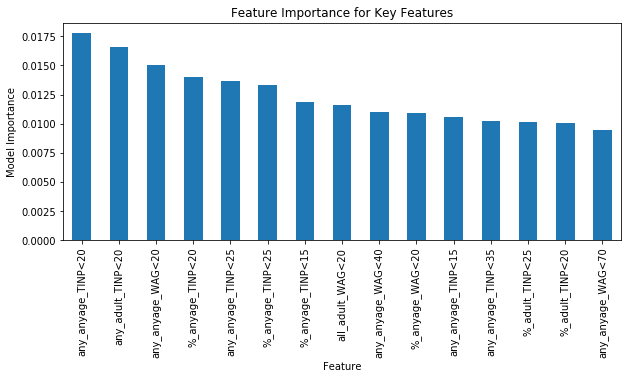

In [14]:
# Plot importance of key features
fig, ax = plt.subplots(figsize=(10,4))
test_imps.head(15).plot(kind='bar', ax=ax, legend=None)
ax.set_title('Feature Importance for Key Features')
ax.set_xlabel('Feature')
ax.set_ylabel('Model Importance');

What about factors that are not strictly financial?  Specifically, things that people may have more control over, like 
education levels?

Below are the DataFrame and a chart of the key non-financial factors. We see a couple of things:
1. The relative importance to the model of these factors is much lower than the top-rated wage-related features. The
top-rated overall feature is roughly 15x more important to the model than the top feature below.
2. With that out of the way, the educational attainment of the head of the household ('SCHL_1') is the most important feature on 
this list. Focusing on improving educational opportunities, and tailoring them to communities of need, could improve
poverty rates. For individual households with little opportunity to improve their wages in their current role, 
education would be the most powerful non-financial way to improve their poverty status.
3. Disability status is important, with a variation on disability status of household members appearing in 8 of the 15 
most-important features listed below (any feature with 'DIS' in the name). While there's little or nothing that a household can do about their disability 
status, this suggests an opportunity for local governments in focusing poverty efforts.
4. Citizenship and English-speaking ability of the head of the household ('CIT_1' and 'ENG_1')rank highly on this list. While citizenship may be more difficult to change,
English-speaking ability can be improved at little cost over time; and local governments can focus efforts and programs
to communities with poor English skills and non-citizens.
5. Total work hours for the poverty unit ('TotalWorkHrs_PU') is also an important factor, as we saw in EDA (the poverty rate 
among households with less than the equivalent of one 20 hours/week job is over 40%). Local governments can identify
households under this threshold and target specific programs (e.g. childcare or older-adult care) to enable households
to gain more work hours.

In [15]:
non_fin_vars = ['AGEP', 'CIT', 'SCH', 'SCHG', 'SCHL', 'SEX', 'ESR', 'LANX', 'ENG', 'MSP', 'MAR', 'WKW', 'WKHP', 
                    'DIS', 'TEN', 'HHT', 'JWTR', 'Povunit_Rel', 'FamType_PU', 'Ethnicity', 
                    'TotalWorkHrs_PU', 'Boro', 'EducAttain', 'CitizenStatus', 'AgeCateg', 'FTPTWork']
check_non_fin = lambda string: any (v in string for v in non_fin_vars)
non_fins = test_imps.T[[x for x in test_imps.T.columns if check_non_fin(x)]].T.head(15)
non_fins

,Importance
SCHL_1,0.001205
max_18-64_not_DIS,0.001204
count_anyage_not_DIS,0.000991
CIT_1,0.000942
count_adult_not_DIS,0.000909
ENG_1,0.000908
mean_anyage_not_DIS,0.000892
TotalWorkHrs_PU,0.000865
any_18-64_not_DIS,0.000859
sum_18-64_not_DIS,0.000855


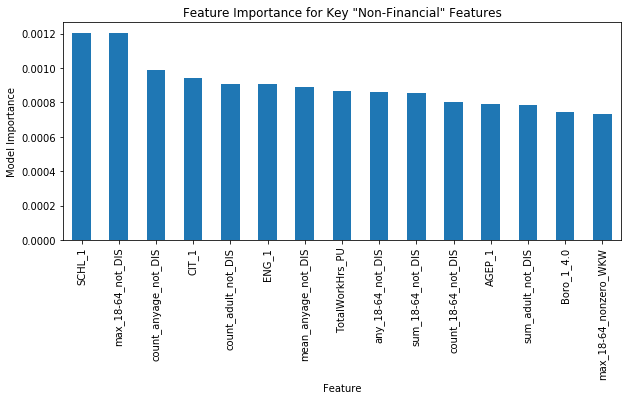

In [16]:
# Plot importance of key features
fig, ax = plt.subplots(figsize=(10,4))
non_fins.plot(kind='bar', ax=ax, legend=None)
ax.set_title('Feature Importance for Key "Non-Financial" Features')
ax.set_xlabel('Feature')
ax.set_ylabel('Model Importance');

### LIME with Random Forest Classifier
Below we see a couple of examples of data points, and why they were classified as they were. For the first point, the
household is not in poverty; looking at the chart below, we can see why.

Our variables that end in _1, _2, _3, etc. indicate person 1 in the household, person 2 in the household, etc.

Interestingly, this household has no wages for person 1, 2, or 3, which would suggest the household is in poverty (see 
the green bars to the right of the chart); but the first person is either self-employed or independently wealthy, as 
they have a total income of over \\$67,000 despite no wages (red bar).  Thus, they are correctly identified as not in
poverty.

In [17]:
#y_test[7] # 0 means not in poverty
predictions[7] # 0 means not in poverty

0.0

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Took 76.11745142936707 s


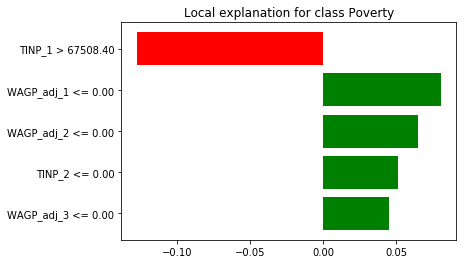

In [18]:
time_0 = time.time()

# Specify the prediction function for use with LIME
predict_fn = lambda x: rf_pipeline.predict_proba(x)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = X_train.columns, 
                                                   class_names = ['Not Poverty', 'Poverty'])

np.random.seed(42)
i = 7
exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=5)
exp.as_pyplot_figure()

time_took = time.time() - time_0
print('Took ' + str(time_took) + ' s')

Here's an example of a household in poverty.  As we can see below, there's no wages for person 1, 2, or 3; no income for
person 2; and person 1 has less than \\$10,000 in total income.  This is a household in poverty.

In [30]:
#y_test[1657] # 1 means in poverty
predictions[1657] # 1 means in poverty

1.0

Took 39.19771933555603 s


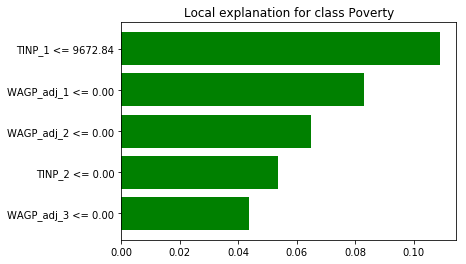

In [20]:
time_0 = time.time()

# Since predict_fn and explainer were calculated above, commenting them out here
#predict_fn = lambda x: rf_pipeline.predict_proba(x)
#explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = X_train.columns, class_names = ['Not Poverty', 'Poverty'])

np.random.seed(42)
i = 1657
exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=5)
exp.as_pyplot_figure()

time_took = time.time() - time_0
print('Took ' + str(time_took) + ' s')

### Modeling with Balanced Random Forest Classifier
Because our data is unbalanced (~20% of the sample is in poverty), our model will have a harder time identifying 
households that are in poverty. We can achieve better accuracy on households in poverty by using a Balanced Random 
Forest Classifier, at the expense of some overall accuracy.

Below we see with a Balanced Random Forest Classifier, we get a total accuracy of about 90% (worse than the almost 93% 
with the Random Forest Classifier), but balanced accuracy and geometric mean of 91% (compared to about 88% above).

In [21]:
# Pull off 'NYCgov_Pov_Stat' for our target variable
y = X_and_y['NYCgov_Pov_Stat']
#y.replace({1: 'Pov', 2:'Not Pov'}, inplace=True)
y.replace({2:0}, inplace=True) # Original coding is 1 in pov, 2 not in pov
X = X_and_y.drop('NYCgov_Pov_Stat', axis='columns')

# Get train and test - be sure to stratify since this is imbalanced data (poverty ~20% of the set)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

scaler = Normalizer()
classifier = BalancedRandomForestClassifier(n_estimators=1000, n_jobs=-1, max_features='auto', oob_score=True,
                                            random_state=42)
cachedir = tempfile.mkdtemp(dir='/mnt/ssd/tmp')

# Create empty dictionaries to hold results
results_1000_estimators = {}

brf_pipeline = imbPipeline(steps=[('scaler', scaler), ('clf', classifier)],  memory=cachedir)

t0 = time.time()
brf_pipeline.fit(X_train, y_train)

time_to_fit = time.time() - t0
print('Took: ' + '{:4.2f}'.format(time_to_fit) + 's to fit ')

predictions = brf_pipeline.predict(X_test)

print('\nAccuracy: ' + str(brf_pipeline.score(X_test, y_test)))
print('Balanced accuracy: ' + str(balanced_accuracy_score(y_test, predictions)))
print('Geometric mean: ' + str(geometric_mean_score(y_test, predictions)))
print('Confusion matrix:\n' + str(confusion_matrix(y_test, predictions)))
print('\nClassification report:\n' + str(classification_report_imbalanced(y_test, predictions)))
print('OOB score: ' + str(brf_pipeline.named_steps['clf'].oob_score_))
print('n_estimators: ' + str(brf_pipeline.named_steps['clf'].n_estimators))
print('Features: ' + str(len(X_and_y.columns)))

# Save the model
dump(brf_pipeline, 'data/brf_pipeline.joblib') 
# brf_pipeline = load('data/brf_pipeline.joblib')

/home/ubuntu/.local/lib/python3.5/site-packages/imblearn/pipeline.py:197: UserWarning: Persisting input arguments took 0.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


Took: 158.60s to fit 

Accuracy: 0.8986315255955398
Balanced accuracy: 0.9124890541761589
Geometric mean: 0.9121844230829197
Confusion matrix:
[[4177  522]
 [  78 1142]]

Classification report:
                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.89      0.94      0.93      0.91      0.83      4699
        1.0       0.69      0.94      0.89      0.79      0.91      0.84      1220

avg / total       0.92      0.90      0.93      0.90      0.91      0.83      5919

OOB score: 0.9254096975840513
n_estimators: 1000
Features: 1554


['data/brf_pipeline.joblib']

### Feature Importance with Balanced Random Forest Classifier
Does this model show us any differences in the importance of features? On the whole, there's nothing earth-shattering.
Instead of a wage of \\$70,000 being in the top-15 as above, it's a wage of \\$80,000, and it's actually the 11th most 
important in this model.

In [22]:
# Get feature importances and sort
brf_imps = list(zip(brf_pipeline.named_steps['clf'].feature_importances_, X_train.columns))
brf_imps = sorted(brf_imps, key=lambda tup: tup[0], reverse=True)

# Put them into a DataFrame for easy manipulation
data_brf = [tup[0] for tup in brf_imps]
index_brf = [tup[1] for tup in brf_imps]
brf_imps = pd.DataFrame(data=data_brf, index=index_brf, columns=['Importance'])

brf_imps.head(15)

,Importance
any_anyage_TINP<20,0.021380
%_adult_TINP<20,0.019254
count_adult_TINP<20,0.018400
%_anyage_TINP<20,0.016419
any_anyage_TINP<25,0.015935
%_adult_TINP<25,0.015337
any_anyage_TINP<30,0.015120
any_adult_TINP<20,0.015058
any_anyage_WAG<25,0.014472
%_anyage_TINP<25,0.014061


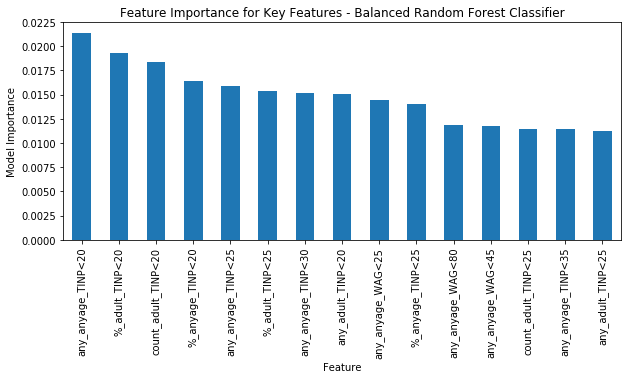

In [23]:
# Plot importance of key features
fig, ax = plt.subplots(figsize=(10,4))
brf_imps.head(15).plot(kind='bar', ax=ax, legend=None)
ax.set_title('Feature Importance for Key Features - Balanced Random Forest Classifier')
ax.set_xlabel('Feature')
ax.set_ylabel('Model Importance');

What about non-financial measures? Since this model is more sensitive to those in poverty, it's interesting to see how 
it differs there.

First of all, the most important feature overall is about 20 times more important than the most important non-financial
feature (it was a factor of 15x in our random forest).  As for the features themselves:
1. Disability status is still a huge factor here, with the top and 5 of the top 15 features being disability-related.
2. Educational attainment of the head of the household ('SCHL_1') is the second-most important on this list.
3. Work hours is actually much more important in this model, with 7 of the top 15 non-financial features being related
to work hours ('TotalWorkHrs_PU' and the various features with 'WKW' in their names).
4. Again, English-speaking ability and citizenship status of the head of the household are among the most important non-
financial factors in poverty status.

In [24]:
non_fins_brf = brf_imps.T[[x for x in brf_imps.T.columns if check_non_fin(x)]].T.head(15)
non_fins_brf

,Importance
count_anyage_not_DIS,0.001015
SCHL_1,0.000776
TotalWorkHrs_PU,0.000735
min_adult_>40WKW,0.000688
min_18-64_nonzero_WKW,0.000611
ENG_1,0.000599
min_adult_nonzero_WKW,0.000598
max_adult_>40WKW,0.000596
any_18-64_not_DIS,0.000594
max_adult_nonzero_WKW,0.000592


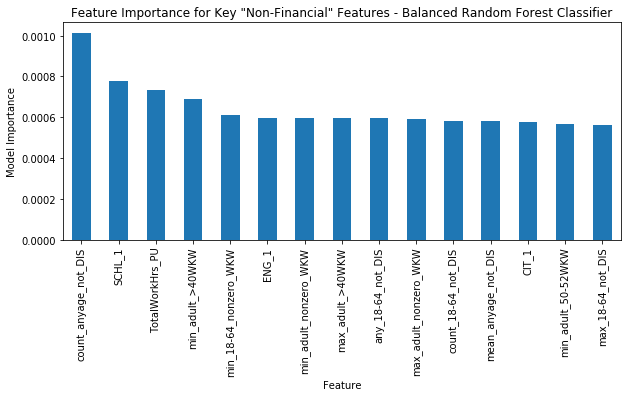

In [25]:
# Plot importance of key features
fig, ax = plt.subplots(figsize=(10,4))
non_fins_brf.plot(kind='bar', ax=ax, legend=None)
ax.set_title('Feature Importance for Key "Non-Financial" Features - Balanced Random Forest Classifier')
ax.set_xlabel('Feature')
ax.set_ylabel('Model Importance');

### LIME with Balanced Random Forest Classifier
Below we see a couple of examples of data points, and why they were classified as they were. For the first point, the household is not in poverty; looking at the chart below, we can see why.

Our variables that end in _1, _2, _3, etc. indicate person 1 in the household, person 2 in the household, etc.

This household has no wages for person 2 or 3, and no total income for person 2.  Since person 1 has wages less than
\\$14,000 and total income less than \\$10,000, the model correctly predicts poverty.

In [26]:
#y_test[4] # 1 means in poverty
predictions[4] # 1 means in poverty

1.0

/home/ubuntu/.local/lib/python3.5/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Took 74.67050743103027 s


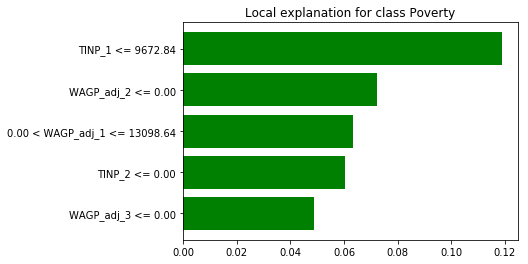

In [27]:
time_0 = time.time()

# Specify the prediction function for use with LIME
predict_fn = lambda x: brf_pipeline.predict_proba(x)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = X_train.columns, 
                                                   class_names = ['Not Poverty', 'Poverty'])

np.random.seed(42)
i = 4
exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=5)
exp.as_pyplot_figure()

time_took = time.time() - time_0
print('Took ' + str(time_took) + ' s')

For the point below, the total income and wages of person 1 and person 2 are so high, this household is pretty obviously
not in poverty. The strongest piece of evidence that this household might be in poverty is that the head of the 
household has no interest/dividends/rental property income (INTP_adj_1 in green), which is clearly not sufficient.

In [28]:
#y_test[4242] # 0 means not in poverty
predictions[4242] # 0 means not in poverty

0.0

Took 39.43708562850952 s


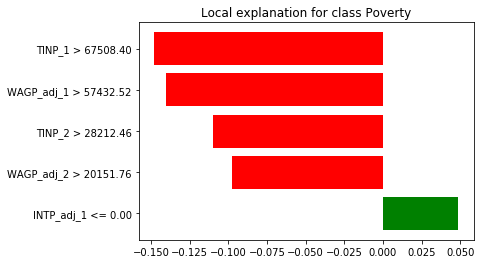

In [31]:
time_0 = time.time()

# Since predict_fn and explainer were calculated above, commenting them out here
#predict_fn = lambda x: brf_pipeline.predict_proba(x)
#explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = X_train.columns,  class_names = ['Not Poverty', 'Poverty'])

np.random.seed(42)
i = 4242
exp = explainer.explain_instance(X_test.values[i], predict_fn, num_features=5)
exp.as_pyplot_figure()

time_took = time.time() - time_0
print('Took ' + str(time_took) + ' s')

### Summary

To summarize:
1. We can develop a model to predict NYC Poverty Status using only the ACS variables with 92.9% accuracy and 88.8% 
balanced accuracy, using a Random Forest Classifier with appropriate feature engineering.
2. Since NYC poverty status is imbalanced (about 20% of households are in poverty), we can further improve our 
sensitivity to poverty households using a Balanced Random Forest Classifier, at the expense of some of our total 
accuracy. In this situation, we can achieve a 89.9% total accuracy and 91.2% balanced accuracy.
3. The financial features (total personal income and personal wages) dominate the poverty prediction models. The top-15
features of both models are personal income and wage-related. In particular, for predicting poverty, the features that
focus on total income or wages in the \\$20,000, \\$25,000, \\$30,000 range are the most relevant.
4. Among non-financial variables like education or English-speaking ability, the most important are the education level
of the head of the household, the disability status of anyone in the household, the citizenship and English-speaking 
ability of the head of the household, and the number of total work hours available to the household.